In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Loading the data
data = pd.read_csv('diabetes.csv')

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Count of missing values in each feature: \n", missing_values)

Count of missing values in each feature: 
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [4]:
# Describe the data
print(data.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

### Handling Data Issues

- **Glucose levels under 20**: Typically indicate a coma, and are usually the result of missing data or errors in data entry.
- **Blood pressure of 0**: Suggests the individual has passed away, and is considered a missing value.
- **Skin thickness of 0**: Implies no skin measurement, which is treated as a missing value.
- **Insulin level of 0**: It is possible in some cases, but values above 300 do not typically occur, even in extreme disease conditions. However, due to insulin injection, such values can occur. Injected insulin is distinguishable from the body's natural insulin. These values are not deleted because there are many of them, and they don't appear to be random or simply missing data. Additionally, the exact conditions under which the dataset was collected are not fully known.
- **BMI under 9**: Is unrealistic, indicating either a data entry mistake or missing information.

### Data Handling Strategy

To address these issues:
1. I will **replace** erroneous or missing values with **median values**. Deleting them would significantly reduce the dataset size, which could affect the analysis.
2. I will **avoid using mean values**, as many health datasets don't follow a normal distribution. Using the median helps reduce the influence f outliers.
f outliers.
f outliers.
f outliers.
of outliers.
f outliers.


In [5]:
# Replace unwanted values with NaN (null)
data.loc[data['Glucose'] < 20, 'Glucose'] = np.nan
data.loc[data['SkinThickness'] == 0 , 'SkinThickness'] = np.nan
data.loc[data['BMI'] < 9, 'BMI'] = np.nan
data.loc[data['BloodPressure'] == 0 , 'BloodPressure'] = np.nan

# Impute missing values with the median
cols_to_impute = ['Glucose', 'SkinThickness', 'BMI', 'BloodPressure']
for col in cols_to_impute:
    median_val = data[col].median()
    data[col].fillna(median_val, inplace=True)

C:\Users\amirm\AppData\Local\Temp\ipykernel_6356\69388294.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


In [6]:
# Identifying outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((data < lower_bound) | (data > upper_bound)).sum()
print("Count of outliers in each feature: ")
print(outliers)

Count of outliers in each feature: 
Pregnancies                  4
Glucose                      0
BloodPressure               14
SkinThickness               87
Insulin                     34
BMI                          8
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64


In [7]:
# CSV file of records including outliers
def detect_outliers(df):
    outliers = []
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_column = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        
        outliers.append(outliers_column)
    
    return pd.concat(outliers).drop_duplicates()

outliers_data = detect_outliers(data)

outliers_data.to_csv('outliers.csv')

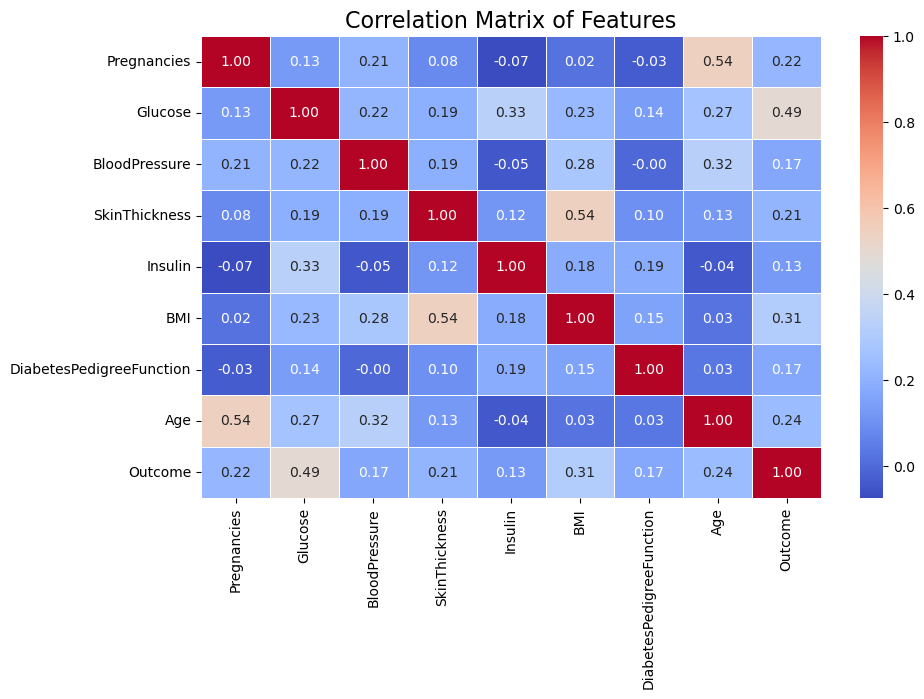

In [8]:
# Correlation Matrix of Features
plt.figure(figsize=(10, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

<Figure size 1200x800 with 0 Axes>

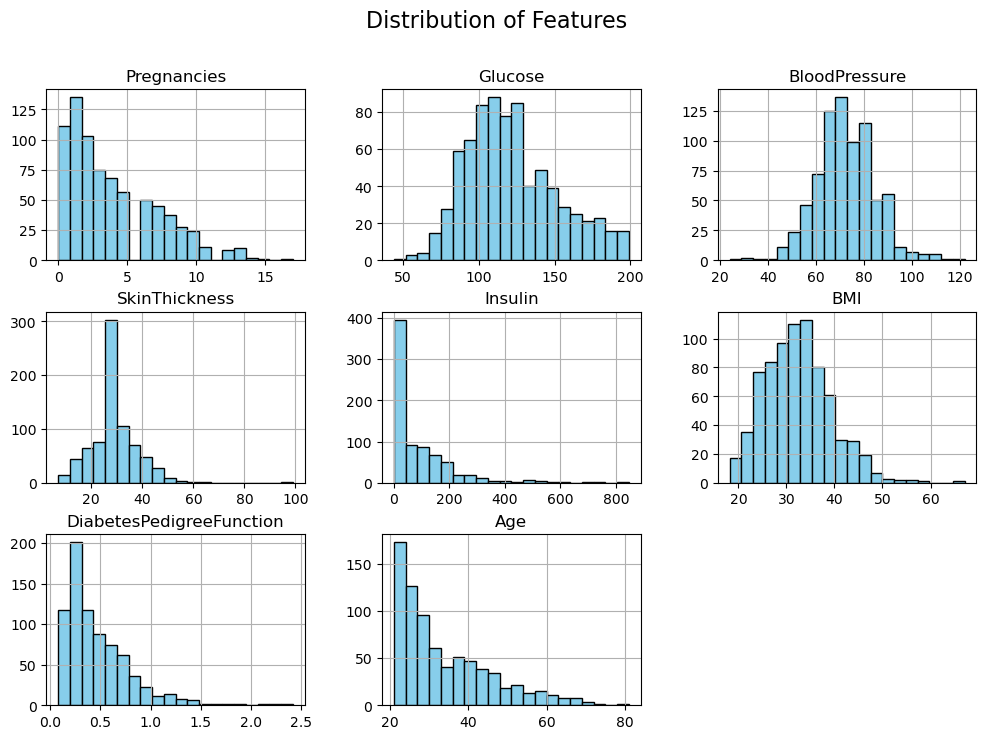

In [9]:
#Distribution of Features
plt.figure(figsize=(12, 8))
data.drop('Outcome', axis=1).hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Features', fontsize=16)
plt.show()

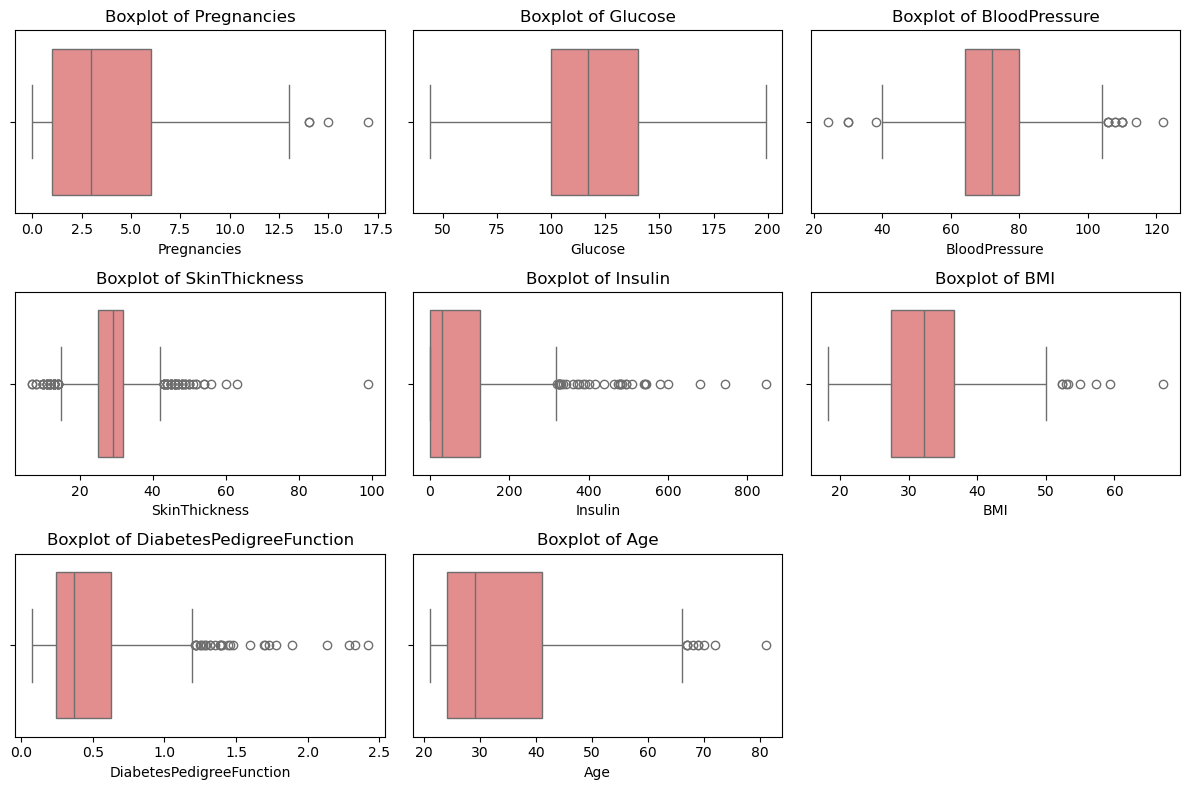

In [10]:
#Box Plot
plt.figure(figsize=(12, 8))
for i, feature in enumerate(data.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=data[feature], color='lightcoral')
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()
plt.show()

### **Feature Selection Justification for Diabetes Dataset**

#### 1. **Removing Insulin**

* **Justification:**

  * Exhibits the **lowest correlation with Outcome** (0.13), suggesting minimal predictive contribution.
  * Contains a **high proportion of zero values**, likely indicating missing or erroneous measurements.
  * **Boxplot analysis reveals extreme outliers** and significant **positive skewness**, making the distribution unreliable.

* **Supporting Evidence:**

  * The **correlation matrix** confirms its weak association with the target variable.
  * **Non-normal distribution** reduces its statistical robustness and may negatively impact model performance.

---

#### 2. **Removing SkinThickness**

* **Justification:**

  * Shows a **moderate correlation with BMI** (0.54), indicating potential redundancy.
  * Numerous outliers observed in the boxplot, with values exceeding **60–80**, suggest possible measurement errors.

* **Supporting Evidence:**

  * **BMI** is a more comprehensive and reliable indicator of obesity.
  * Including both variables may lead to **multicollinearity**, reducing model interpretability.

---

#### 3. **Retaining Pregnancies**

* **Justification:**

  * While moderately correlated with Age (0.54), it holds **distinct clinical relevance**, particularly in assessing **gestational diabetes risk**.
  * Distribution is acceptable (median ≈ 2.5) with **no extreme outliers** in the boxplot.

* **Supporting Evidence:**

  * Unlike Insulin and SkinThickness, **data quality is consistent**.
  * Offers **independent predictive value**, especially in female populations.

---

#### 4. **Key Features to Retain**

* **Glucose:**

  * Displays the **strongest correlation with Outcome** (0.49); a critical predictor of diabetes.

* **BMI:**

  * A robust obesity indicator with a **correlation of 0.31** to Outcome; preferred over SkinThickness.

* **Age:**

  * Correlated with both Pregnancies and Outcome (0.24), providing important **demographic context**.

In [11]:
# Drop unnecessary features
data = data.drop(columns=['Insulin', 'SkinThickness'])

In [12]:
data.describe()

Pregnancies     Glucose  BloodPressure         BMI  \
count   768.000000  768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719   32.455208   
std       3.369578   30.438286      12.096642    6.875177   
min       0.000000   44.000000      24.000000   18.200000   
25%       1.000000   99.750000      64.000000   27.500000   
50%       3.000000  117.000000      72.000000   32.300000   
75%       6.000000  140.250000      80.000000   36.600000   
max      17.000000  199.000000     122.000000   67.100000   

       DiabetesPedigreeFunction         Age     Outcome  
count                768.000000  768.000000  768.000000  
mean                   0.471876   33.240885    0.348958  
std                    0.331329   11.760232    0.476951  
min                    0.078000   21.000000    0.000000  
25%                    0.243750   24.000000    0.000000  
50%                    0.372500   29.000000    0.000000  
75%                    0.626250   41.000000    1.000000  
max                    2.420000   81.000000    1.000000

**From this point onward, due to the skewed distribution, I will first use algorithms that are not affected by it.**

In [13]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

random_states = random.sample(range(1, 1001), 1000)
iterations = 1000

accuracy_dict = {}
accuracy_std_dict = {}
time_dict = {}
best_random_states = {}

In [14]:
# Random Forest Classifier Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)
    
# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

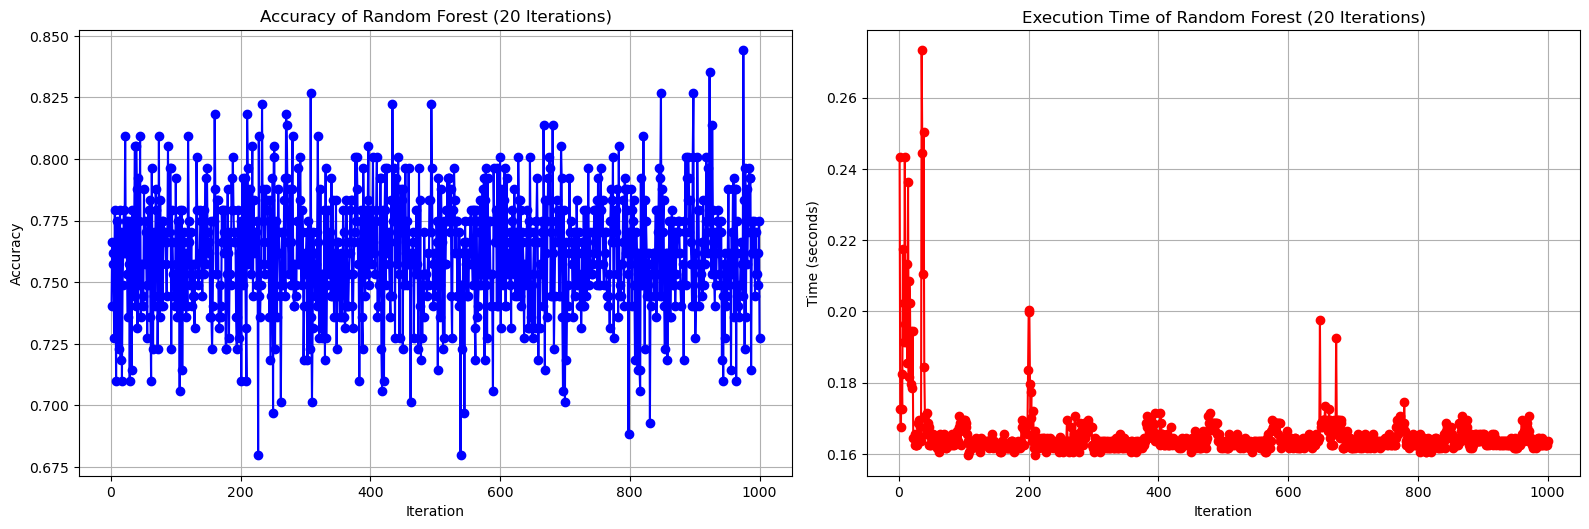

In [15]:
# Creating visualizations
plt.figure(figsize=(16, 10))

# Accuracy performance plot
plt.subplot(2, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Random Forest (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)

# Execution time plot
plt.subplot(2, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Random Forest (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Saving results in respective dictionaries
algorithm_name = "Random Forest (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Random Forest (Raw Data) is 0.7615367965367966
execution time of  Random Forest (Raw Data) is 0.16521669340133666
Accuracy std of Random Forest (Raw Data) is 0.02356099133287573


In [17]:
# Gradient Boosting Classifier Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Gradient Boosting model
    model = GradientBoostingClassifier(n_estimators=100, random_state=i)
    model.fit(X_train, y_train)
    
# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

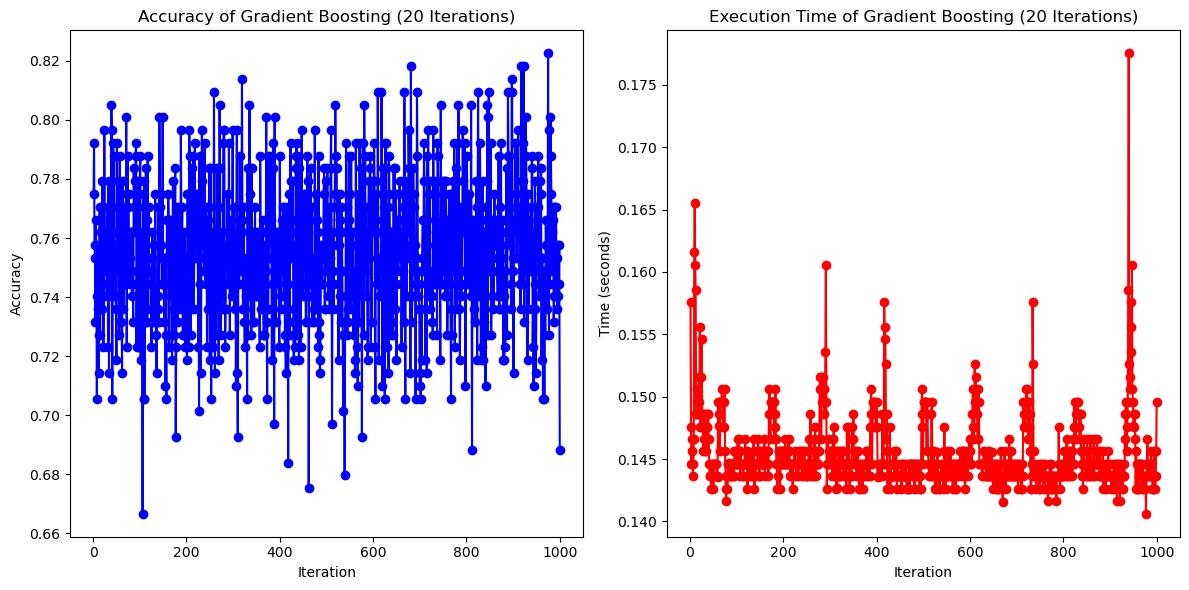

In [18]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gradient Boosting (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gradient Boosting (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [19]:
# Saving results in respective dictionaries
algorithm_name = "Gradient Boosting (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Gradient Boosting (Raw Data) is 0.7549696969696968
execution time of  Gradient Boosting (Raw Data) is 0.14533438801765441
Accuracy std of Gradient Boosting (Raw Data) is 0.02443169619755447


In [20]:
# Decision Tree Classifier Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Decision Tree model
    model = DecisionTreeClassifier(random_state=i)
    model.fit(X_train, y_train)
    
# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

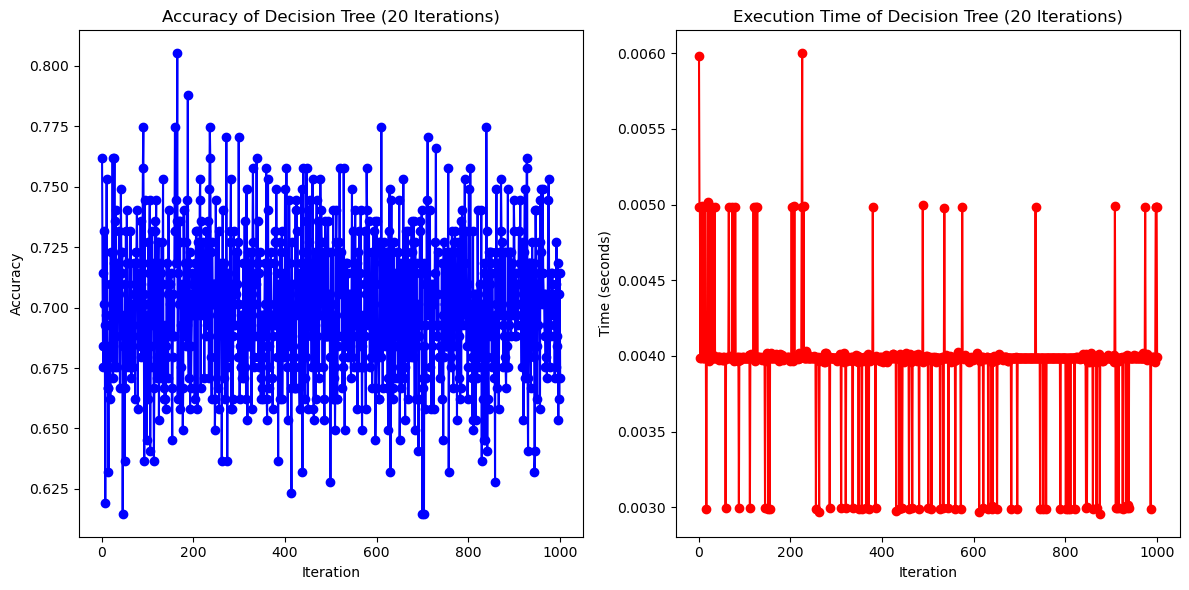

In [21]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Decision Tree (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Decision Tree (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [22]:
# Saving results in respective dictionaries
algorithm_name = "Decision Tree (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of', algorithm_name, 'is', mean_accuracy)
print('execution time of', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of Decision Tree (Raw Data) is 0.699935064935065
execution time of Decision Tree (Raw Data) is 0.0039640309810638425
Accuracy std of Decision Tree (Raw Data) is 0.028771363618703857


In [23]:
# Logistic Regression Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Logistic Regression model
    model = LogisticRegression(max_iter=200, random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

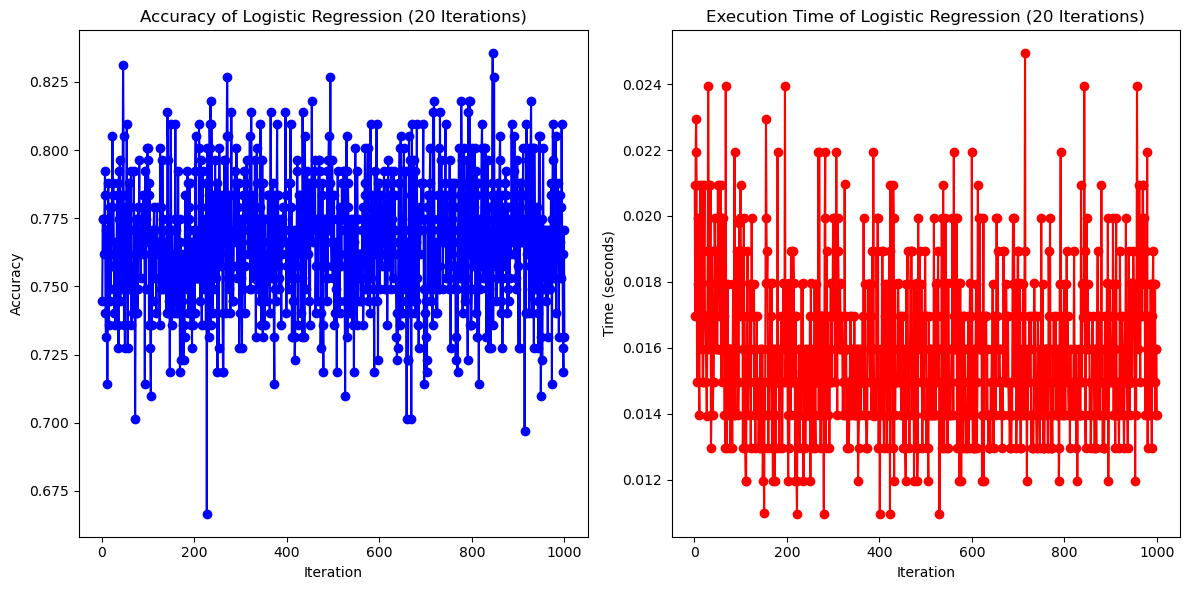

In [24]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [25]:
# Saving results in respective dictionaries
algorithm_name = "Logistic Regression (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Logistic Regression (Raw Data) is 0.7664199134199134
execution time of  Logistic Regression (Raw Data) is 0.015818883657455443
Accuracy std of Logistic Regression (Raw Data) is 0.023235565681254167


In [26]:
# Support Vector Machine with Radial Basis Function Kernel Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building SVM model
    model = SVC(kernel='rbf', random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

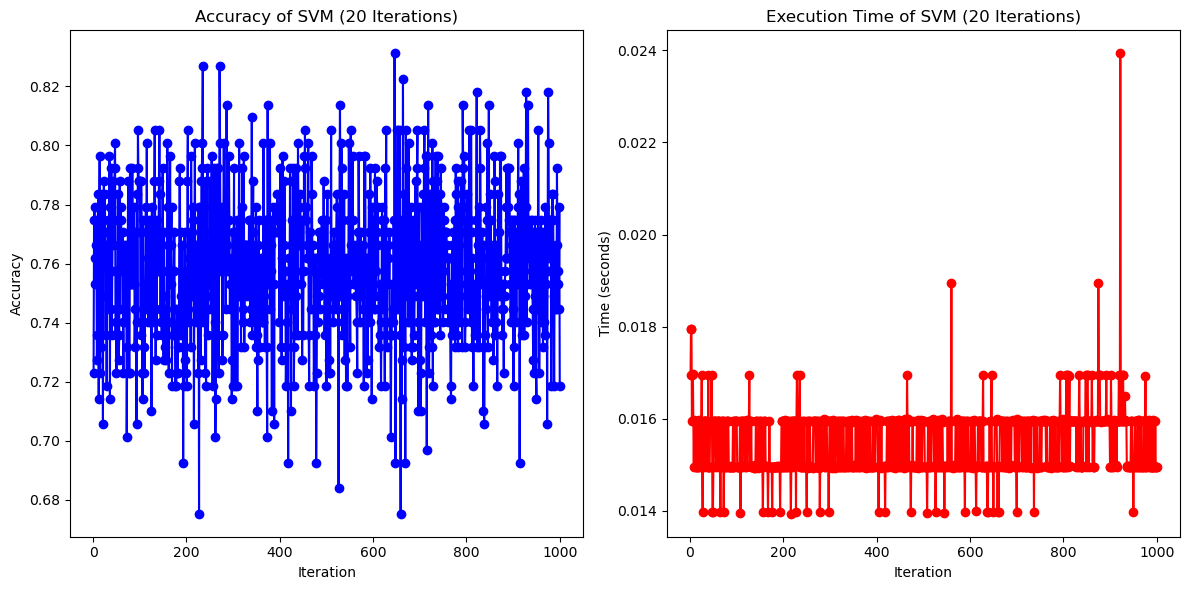

In [27]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [28]:
# Saving results in respective dictionaries
algorithm_name = "SVM (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  SVM (Raw Data) is 0.758904761904762
execution time of  SVM (Raw Data) is 0.015447294950485229
Accuracy std of SVM (Raw Data) is 0.024405278212255743


In [29]:
# KNN Model
model = KNeighborsClassifier()

# Setting parameters for search (for n_neighbors from 1 to 20)
param_grid = {'n_neighbors': list(range(1, 21))}

# GridSearchCV to find the best number of neighbors
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameter and best accuracy
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")

Best n_neighbors: 15
Best Accuracy: 0.7745759778470058


In [30]:
# K Neighbors Classifier Implementation
accuracies = []
times = []
all_random_states = []
n_neighbors = best_n_neighbors
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building KNN model
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

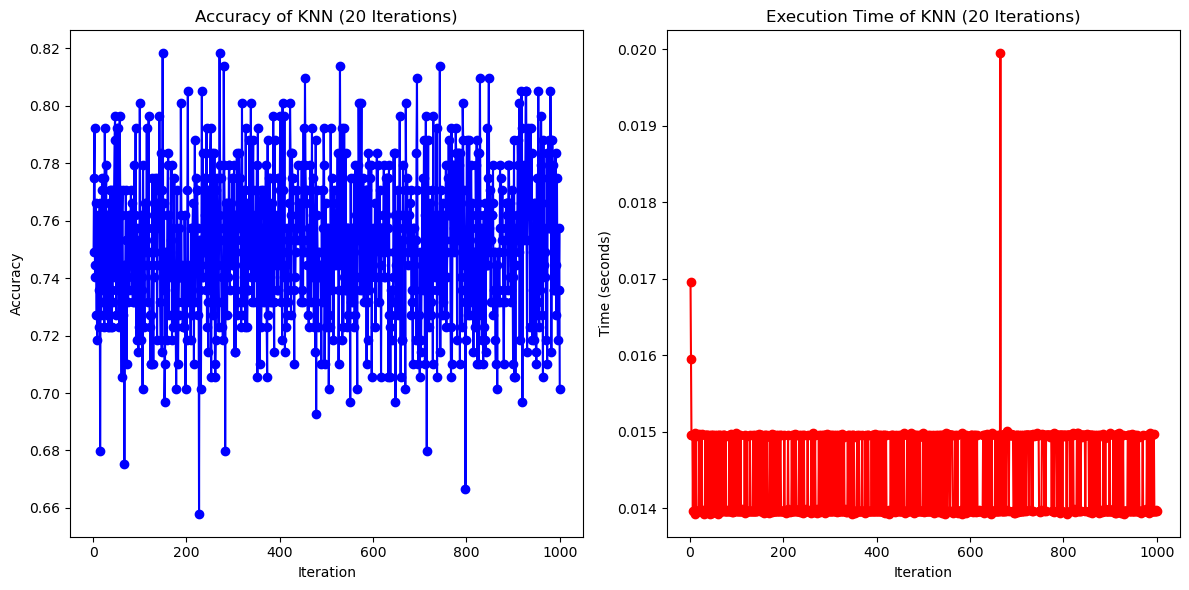

In [31]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [32]:
# Saving results in respective dictionaries
algorithm_name = "KNN (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  KNN (Raw Data) is 0.7509913419913421
execution time of  KNN (Raw Data) is 0.014313127756118774
Accuracy std of KNN (Raw Data) is 0.024656162910028194


In [33]:
# Multi-Layer Perceptron Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Measuring execution time
    start_time = time.time()

# Building MLP model
    model = MLPClassifier(random_state=i, max_iter=3000, solver='adam', hidden_layer_sizes=(100,))
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

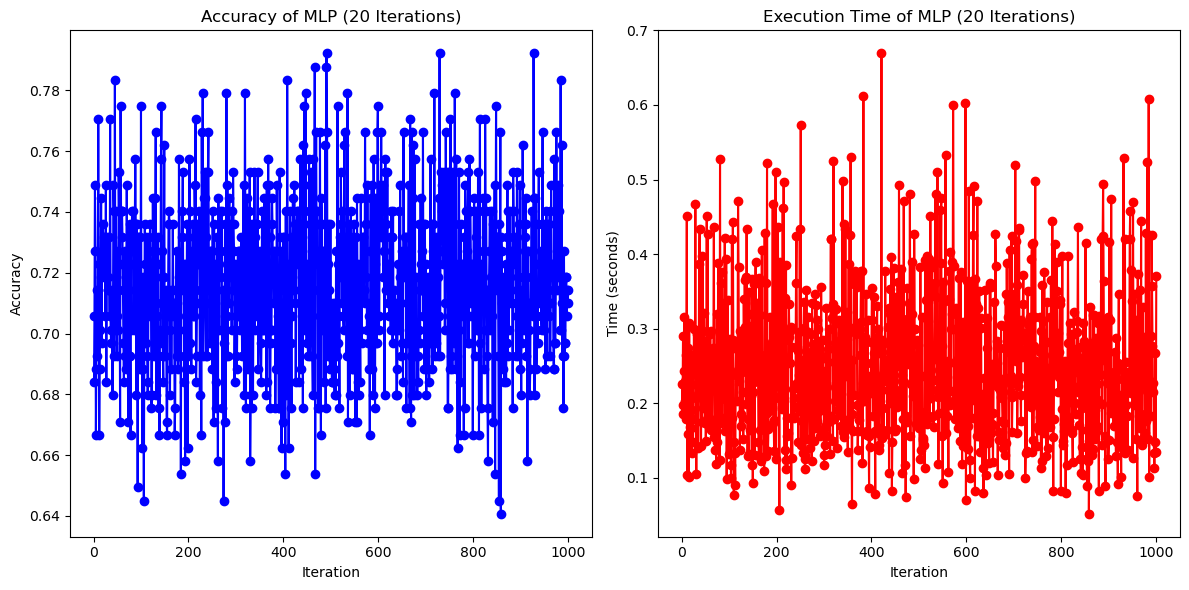

In [34]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [35]:
# Saving results in respective dictionaries
algorithm_name = "MLP (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  MLP (Raw Data) is 0.7162337662337662
Execution time of  MLP (Raw Data) is 0.24891295623779297
Accuracy std of MLP (Raw Data) is 0.02629366812684711


In [36]:
# Gaussian Naive Bayes Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

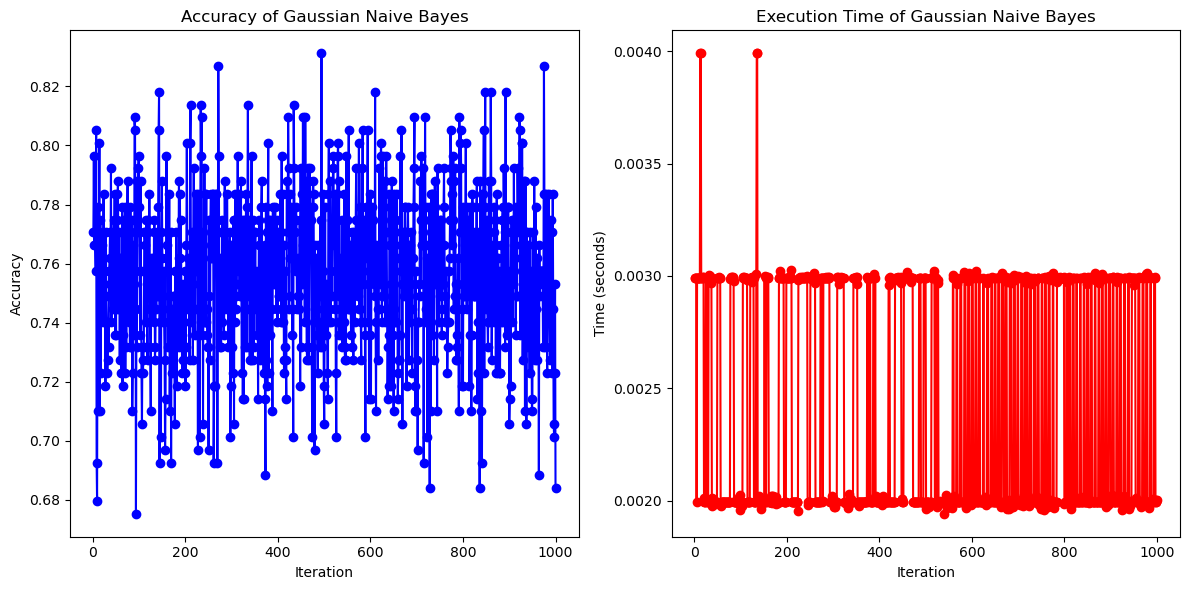

In [37]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [38]:
# Saving results in respective dictionaries
algorithm_name = "Gaussian Naive Bayes (Raw Data)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

# Output the mean values
print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  Gaussian Naive Bayes (Raw Data) is 0.756017316017316
Execution time of  Gaussian Naive Bayes (Raw Data) is 0.002388261079788208
Accuracy std of Gaussian Naive Bayes (Raw Data) is 0.025925062073935624


In [39]:
# Step 1: Work on a copy of the original dataset
data_transformed = data.copy()

# Step 2: Select only numeric columns excluding 'Outcome'
numeric_cols = data_transformed.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols[numeric_cols != 'Outcome']

# Step 3: Calculate initial skewness
initial_skew = data_transformed[numeric_cols].apply(skew)
skewed_initial = initial_skew[abs(initial_skew) > 0.5]
print("📊 Features with skewness > 0.5:\n", skewed_initial)

# Step 4: Apply Yeo-Johnson transformation to highly skewed features
pt = PowerTransformer(method='yeo-johnson')
data_transformed[skewed_initial.index] = pt.fit_transform(data_transformed[skewed_initial.index])

# Step 5: Recalculate skewness after Yeo-Johnson
skew_after_pt = data_transformed[skewed_initial.index].apply(skew)
still_skewed = skew_after_pt[abs(skew_after_pt) > 0.5]
print("\n⚠️ Features still skewed after Yeo-Johnson:\n", still_skewed)

# Step 7: Final skewness report
final_skew = data_transformed[skewed_initial.index].apply(skew)
print("\n✅ Final skewness after Yeo-Johnson only:\n", final_skew)

# Ensure 'Outcome' column is not affected
data_transformed['Outcome'] = data['Outcome']

📊 Features with skewness > 0.5:
 Pregnancies                 0.899912
Glucose                     0.534541
BMI                         0.598062
DiabetesPedigreeFunction    1.916159
Age                         1.127389
dtype: float64

⚠️ Features still skewed after Yeo-Johnson:
 Series([], dtype: float64)

✅ Final skewness after Yeo-Johnson only:
 Pregnancies                -0.044557
Glucose                    -0.001557
BMI                        -0.000356
DiabetesPedigreeFunction    0.142043
Age                         0.149926
dtype: float64


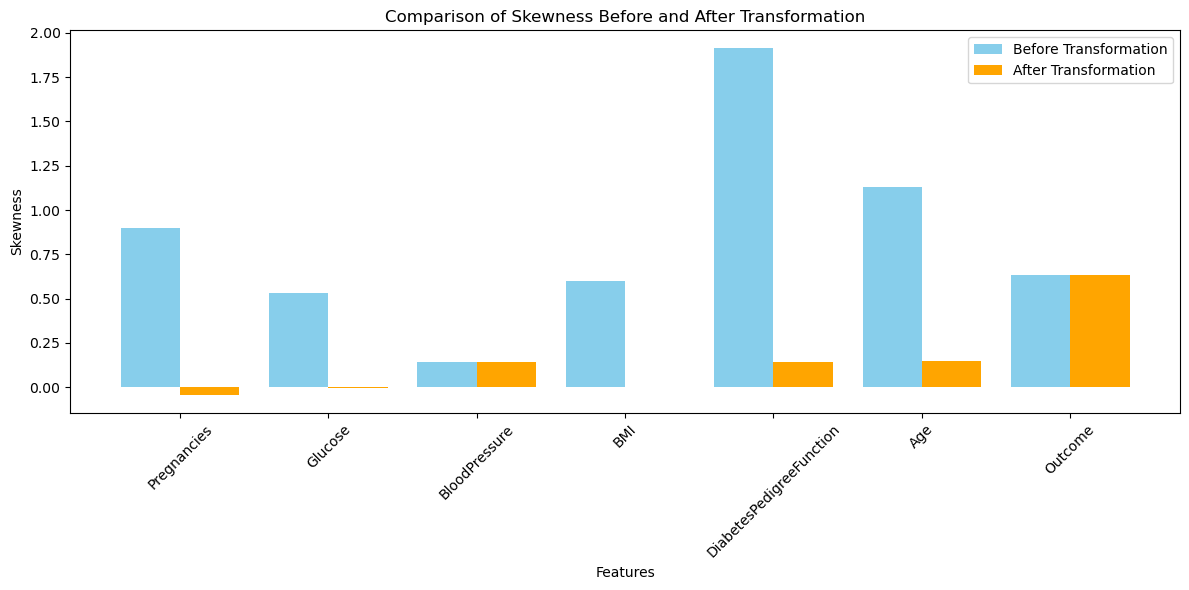

                          Before Transformation  After Transformation  \
Pregnancies                            0.899912             -0.044557   
Glucose                                0.534541             -0.001557   
BloodPressure                          0.141608              0.141608   
BMI                                    0.598062             -0.000356   
DiabetesPedigreeFunction               1.916159              0.142043   
Age                                    1.127389              0.149926   
Outcome                                0.633776              0.633776   

                          Difference  
Pregnancies                -0.944469  
Glucose                    -0.536098  
BloodPressure               0.000000  
BMI                        -0.598417  
DiabetesPedigreeFunction   -1.774116  
Age                        -0.977463  
Outcome                     0.000000  


In [40]:
skew_before = data.apply(lambda x: skew(x))
skew_after = data_transformed.apply(lambda x: skew(x))

# Creating a comparison skewness plot
plt.figure(figsize=(12, 6))

# The number of columns depends on the number of features in the dataframe
n_features = len(data.columns)
x = np.arange(n_features)

# Plotting skewness for data_before
plt.bar(x - 0.2, skew_before, 0.4, label='Before Transformation', color='skyblue')

# Plotting skewness for data_after
plt.bar(x + 0.2, skew_after, 0.4, label='After Transformation', color='orange')

# Adjusting plot settings
plt.xticks(x, data.columns, rotation=45)
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.title('Comparison of Skewness Before and After Transformation')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

# Printing comparison of skewness before and after transformations
comparison_df = pd.DataFrame({
    'Before Transformation': skew_before,
    'After Transformation': skew_after,
    'Difference': skew_after - skew_before
})

print(comparison_df)

<Figure size 1200x800 with 0 Axes>

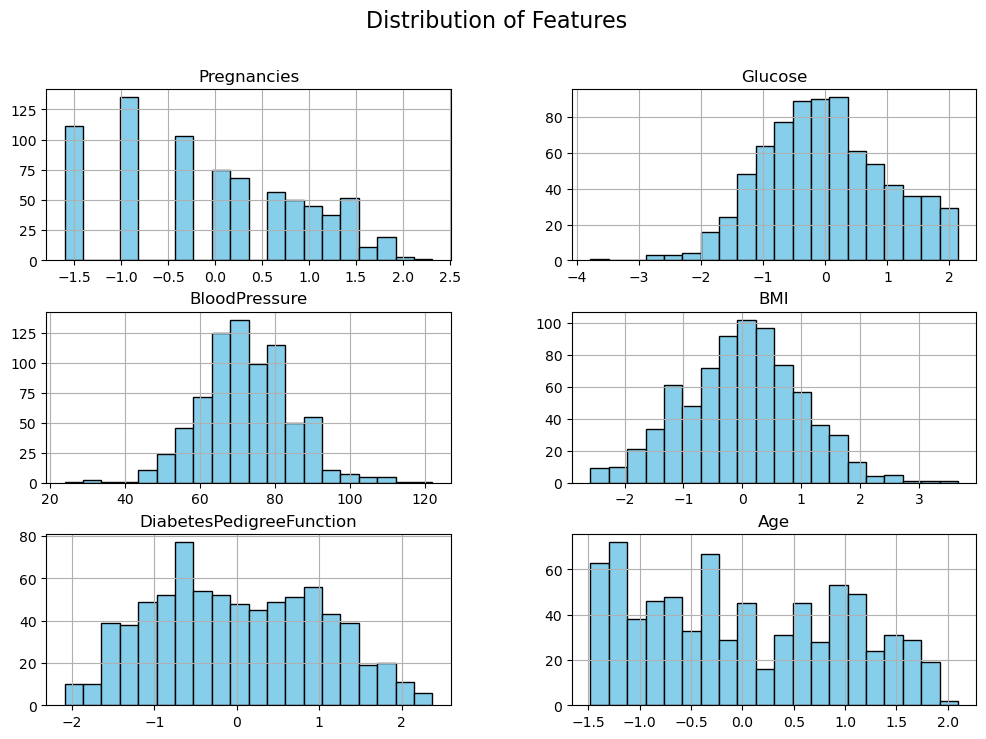

In [41]:
# Visualizing the distribution of features after hadeling skew
plt.figure(figsize=(12, 8))
data_transformed.drop('Outcome', axis=1).hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Features', fontsize=16)
plt.show()

In [42]:
X = data_transformed.drop(columns=['Outcome'])
y = data_transformed['Outcome']

In [43]:
# Random Forest Classifier Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)
    
# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

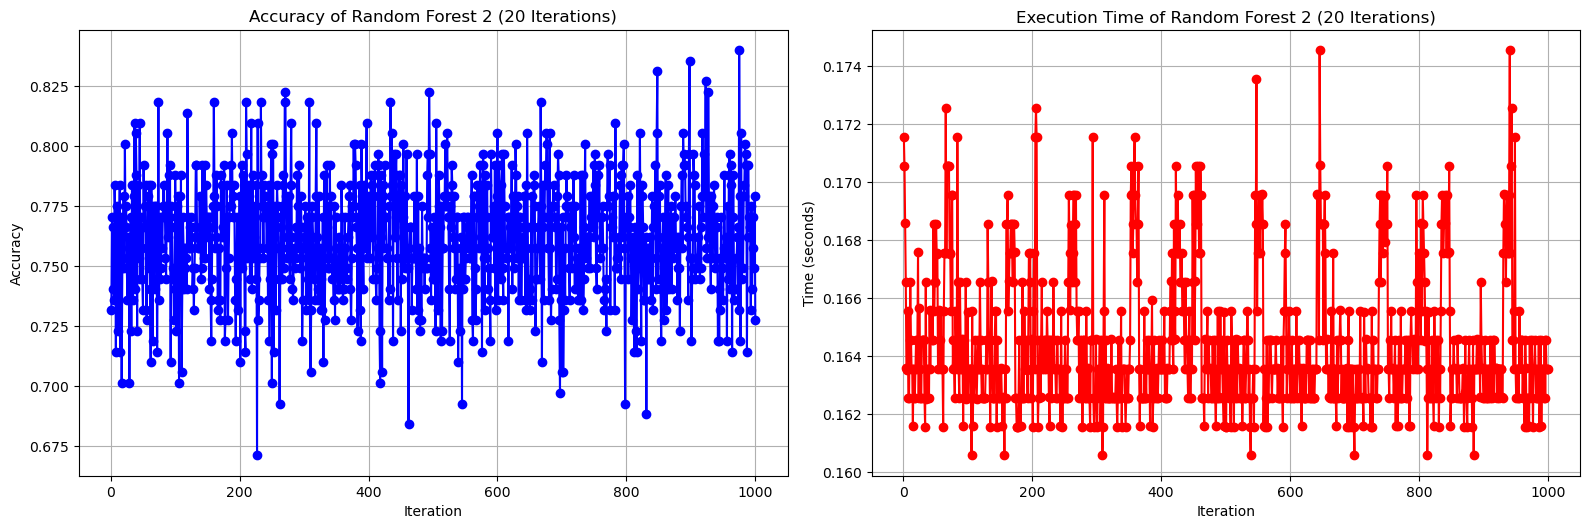

In [44]:
# Creating visualizations
plt.figure(figsize=(16, 10))

# Accuracy performance plot
plt.subplot(2, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Random Forest 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)

# Execution time plot
plt.subplot(2, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Random Forest 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [45]:
# Saving results in respective dictionaries
algorithm_name = "Random Forest (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Random Forest (de-skewed) is 0.7614242424242424
execution time of  Random Forest (de-skewed) is 0.16438843727111815
Accuracy std of Random Forest (de-skewed) is 0.024014341008077044


In [46]:
# Gradient Boosting Classifier Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Gradient Boosting model
    model = GradientBoostingClassifier(n_estimators=100, random_state=i)
    model.fit(X_train, y_train)
    
# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

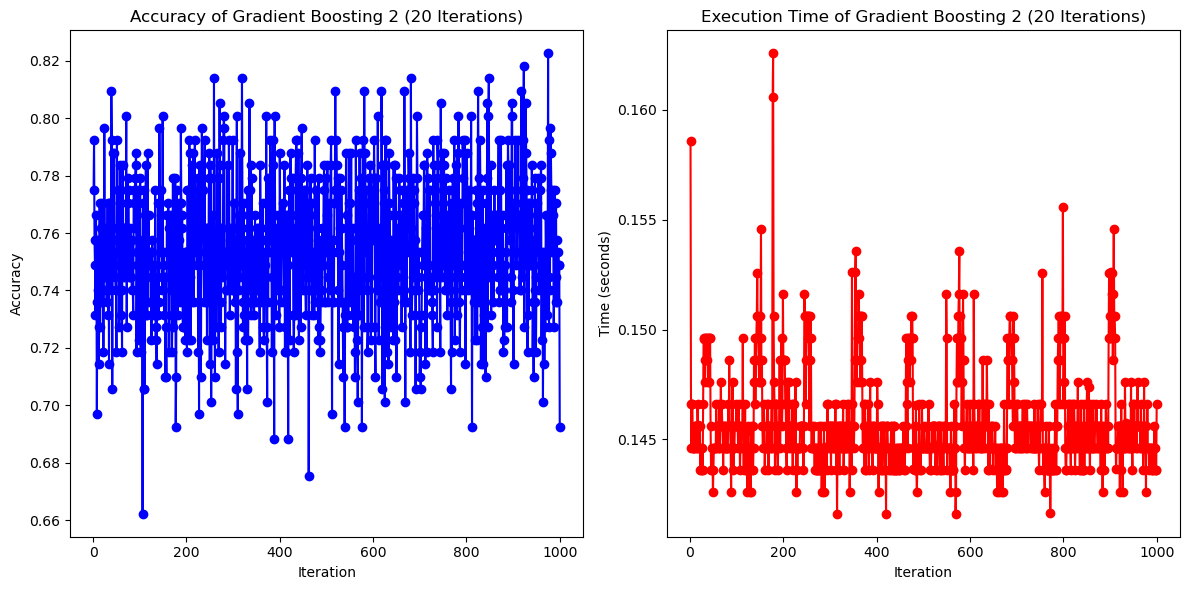

In [47]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gradient Boosting 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gradient Boosting 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [48]:
# Saving results in respective dictionaries
algorithm_name = "Gradient Boosting (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Gradient Boosting (de-skewed) is 0.7541688311688312
execution time of  Gradient Boosting (de-skewed) is 0.14570406103134156
Accuracy std of Gradient Boosting (de-skewed) is 0.024188108214567842


In [49]:
# Decision Tree Classifier Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Gradient Boosting model
    model = DecisionTreeClassifier(random_state=i)
    model.fit(X_train, y_train)
    
# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

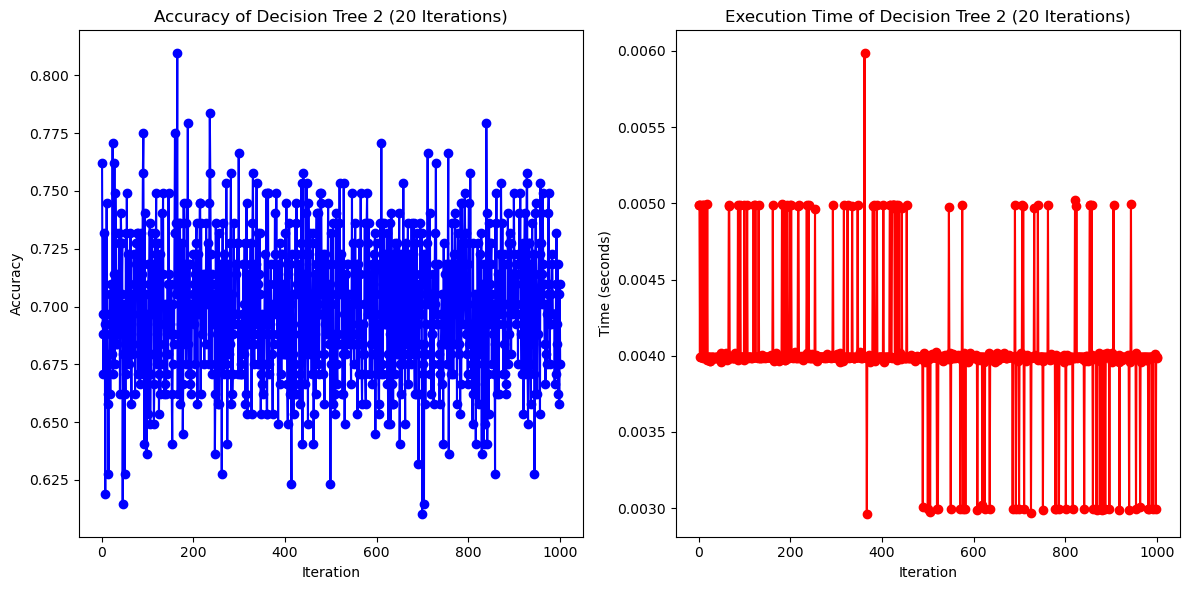

In [50]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Decision Tree 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Decision Tree 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [51]:
# Saving results in respective dictionaries
algorithm_name = "Decision Tree (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Decision Tree (de-skewed) is 0.6990692640692642
execution time of  Decision Tree (de-skewed) is 0.004014375209808349
Accuracy std of Decision Tree (de-skewed) is 0.02881497113994855


In [52]:
# Logistic Regression Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building the Logistic Regression model
    model = LogisticRegression(max_iter=200, random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

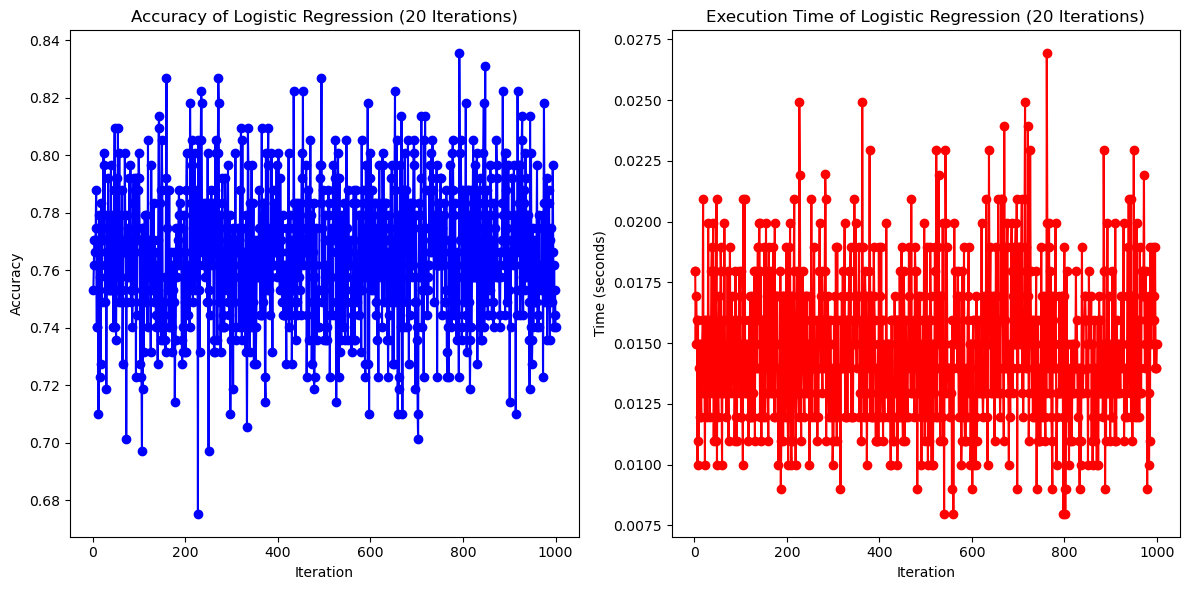

In [53]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [54]:
# Saving results in respective dictionaries
algorithm_name = "Logistic Regression (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Logistic Regression (de-skewed) is 0.7655021645021646
execution time of  Logistic Regression (de-skewed) is 0.014757557392120361
Accuracy std of Logistic Regression (de-skewed) is 0.02327959621820055


In [55]:
# Support Vector Machine with Radial Basis Function Kernel Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building SVM model
    model = SVC(kernel='rbf', random_state=i)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

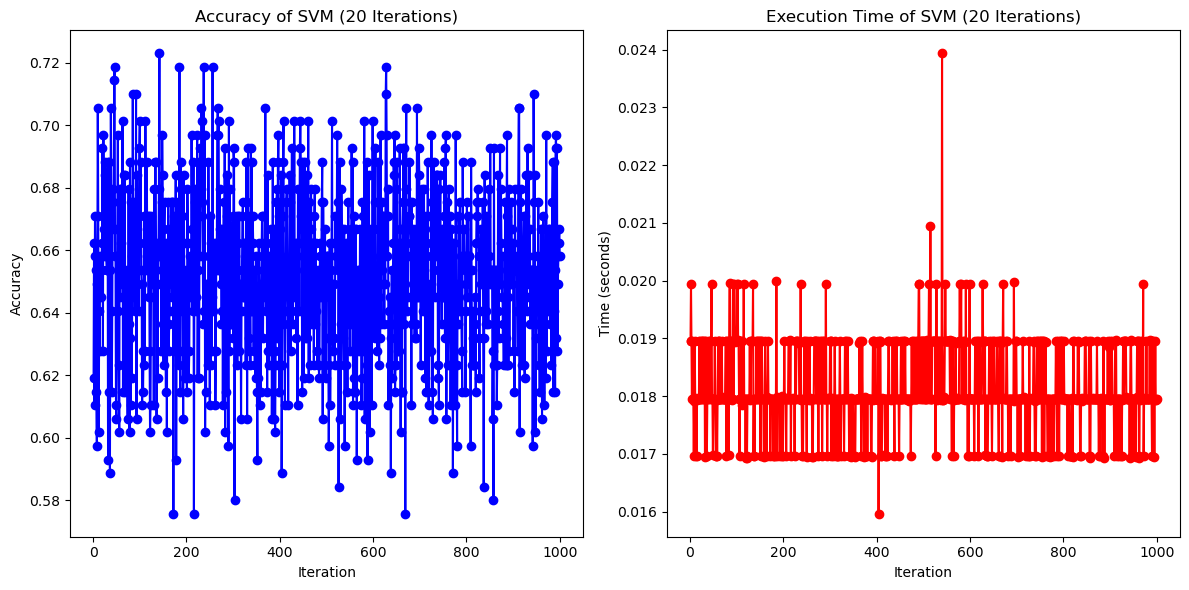

In [56]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [57]:
# Saving results in respective dictionaries
algorithm_name = "SVM (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  SVM (de-skewed) is 0.6519047619047619
execution time of  SVM (de-skewed) is 0.018112144947052003
Accuracy std of SVM (de-skewed) is 0.026407600587519127


In [58]:
# KNN Model
model = KNeighborsClassifier()

# Setting parameters for search (for n_neighbors from 1 to 20)
param_grid = {'n_neighbors': list(range(1, 21))}

# GridSearchCV to find the best number of neighbors
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameter and best accuracy
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")

Best n_neighbors: 7
Best Accuracy: 0.7410868812737972


In [59]:
# K Neighbors Classifier Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
n_neighbors = best_n_neighbors
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building KNN model
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

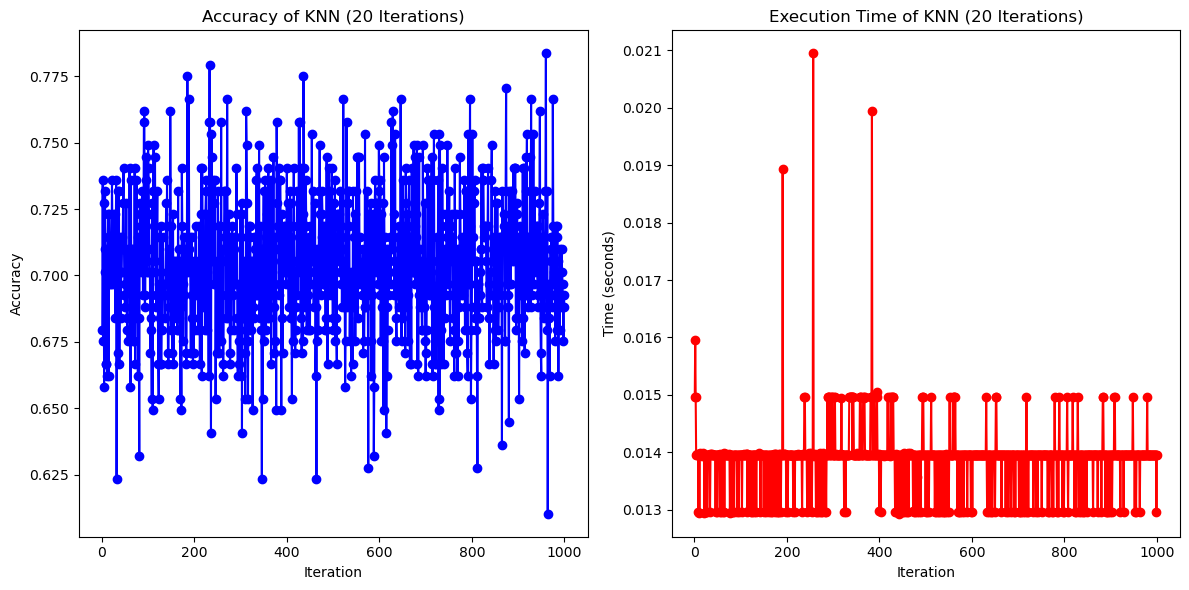

In [60]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [61]:
# Saving results in respective dictionaries
algorithm_name = "KNN (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  KNN (de-skewed) is 0.703891774891775
execution time of  KNN (de-skewed) is 0.013902308940887452
Accuracy std of KNN (de-skewed) is 0.025696277965859205


In [62]:
# Multi-Layer Perceptron Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Measuring execution time
    start_time = time.time()

# Building MLP model
    model = MLPClassifier(random_state=i, max_iter=3000, solver='adam', hidden_layer_sizes=(100,))
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

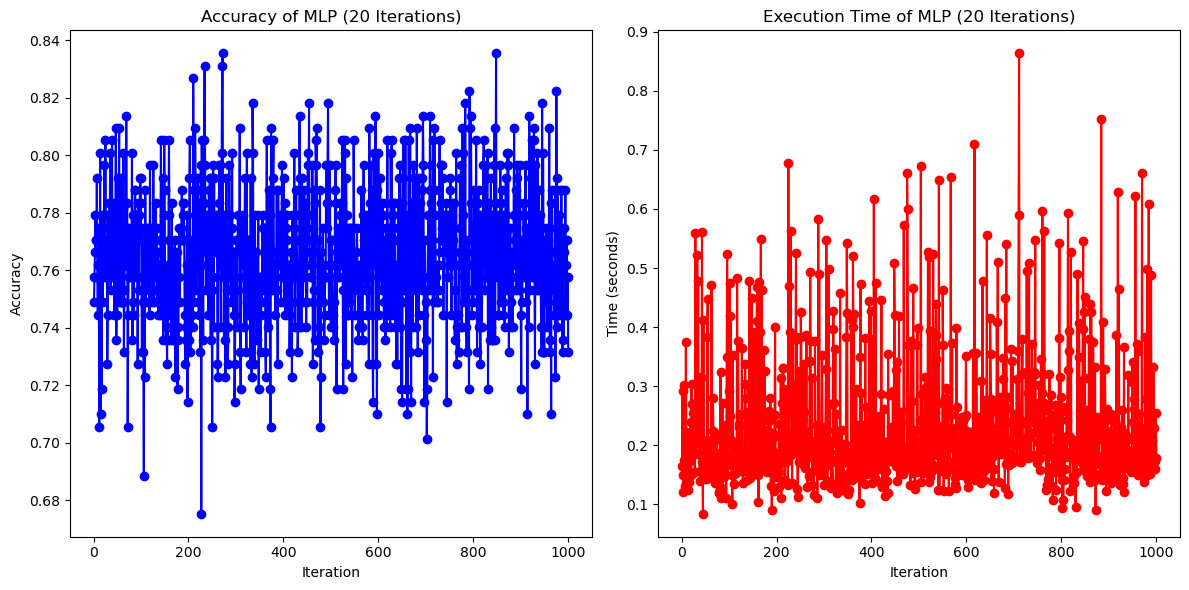

In [63]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [64]:
# Saving results in respective dictionaries
algorithm_name = "MLP (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  MLP (de-skewed) is 0.765025974025974
Execution time of  MLP (de-skewed) is 0.2348911430835724
Accuracy std of MLP (de-skewed) is 0.023613978188621532


In [65]:
# Gaussian Naive Bayes Implementation (de-skewed)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
# Measuring execution time
    start_time = time.time()

# Building Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train, y_train)

# Making predictions
    y_pred = model.predict(X_test)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

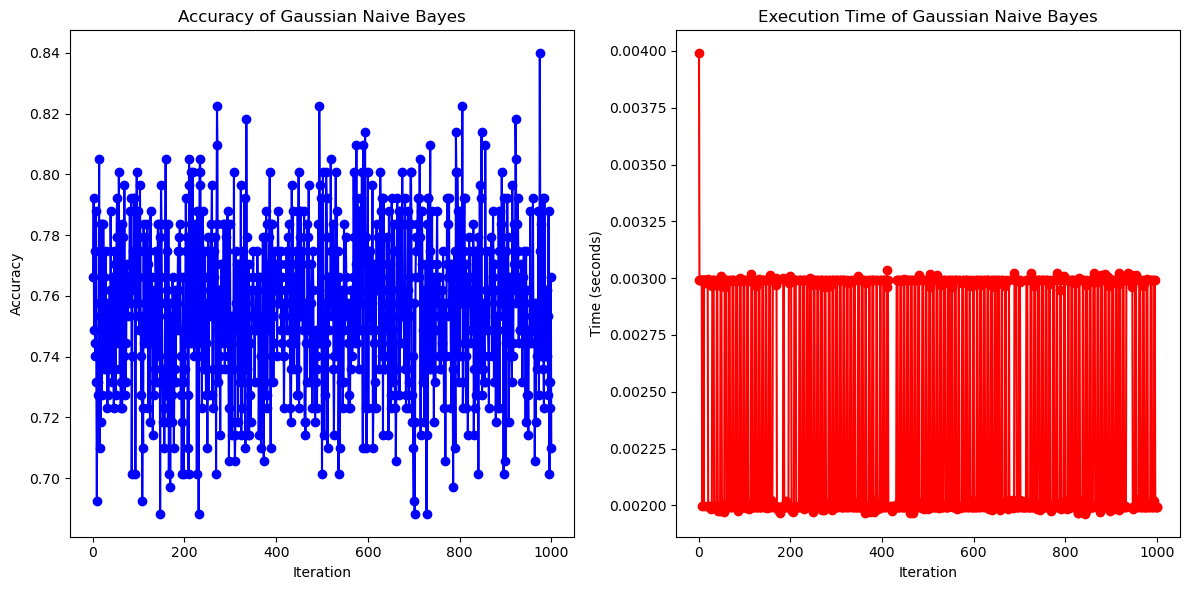

In [66]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [67]:
# Saving results in respective dictionaries
algorithm_name = "Gaussian Naive Bayes (de-skewed)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

# Output the mean values
print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  Gaussian Naive Bayes (de-skewed) is 0.7554285714285714
Execution time of  Gaussian Naive Bayes (de-skewed) is 0.002355794668197632
Accuracy std of Gaussian Naive Bayes (de-skewed) is 0.02521695519996749


In [68]:
# Random Forest Classifier Implementation (Scaled)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)

# Measuring execution time
    start_time = time.time()

# Building the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=i)
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)
    
# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

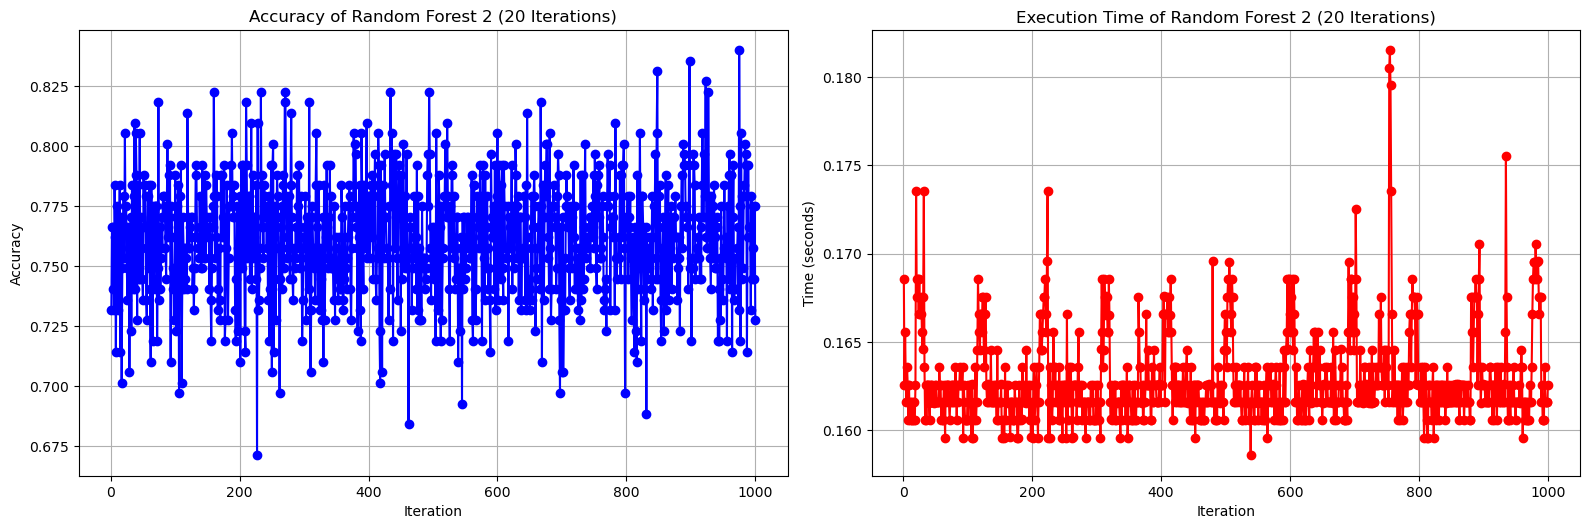

In [69]:
# Creating visualizations
plt.figure(figsize=(16, 10))

# Accuracy performance plot
plt.subplot(2, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Random Forest 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)

# Execution time plot
plt.subplot(2, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Random Forest 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
# Saving results in respective dictionaries
algorithm_name = "Random Forest (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Random Forest (Scaled) is 0.7613419913419914
execution time of  Random Forest (Scaled) is 0.16282294034957887
Accuracy std of Random Forest (Scaled) is 0.024023867931558897


In [71]:
# Gradient Boosting Classifier Implementation (Scaled)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building the Gradient Boosting model
    model = GradientBoostingClassifier(n_estimators=100, random_state=i)
    model.fit(X_train_std, y_train)
    
# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

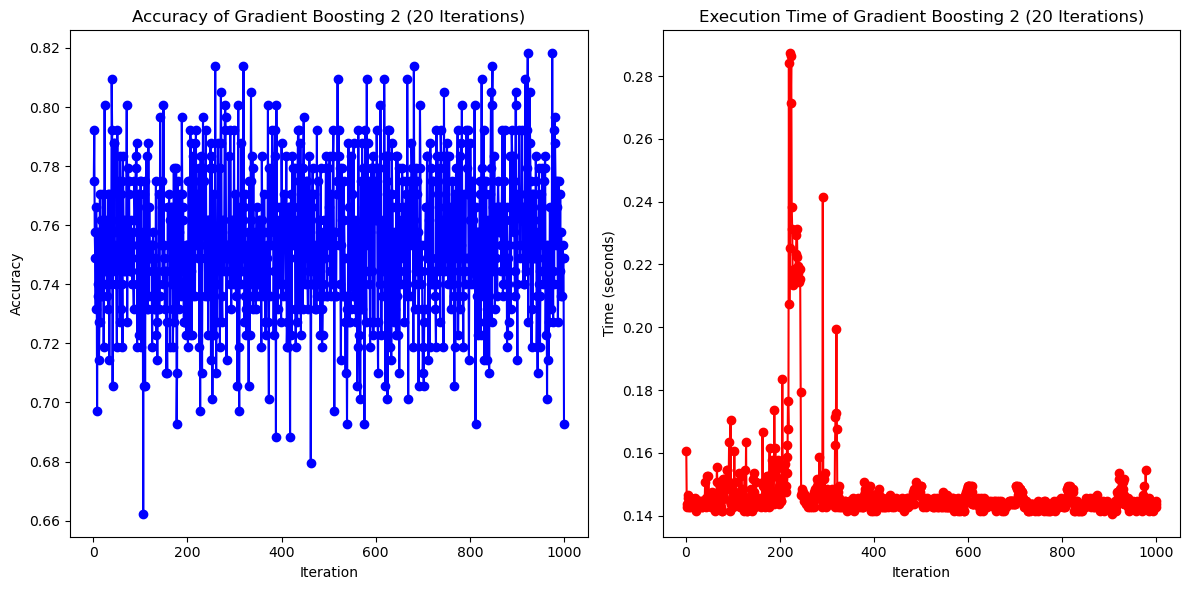

In [72]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gradient Boosting 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gradient Boosting 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [73]:
# Saving results in respective dictionaries
algorithm_name = "Gradient Boosting (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Gradient Boosting (Scaled) is 0.7541818181818182
execution time of  Gradient Boosting (Scaled) is 0.14751462411880492
Accuracy std of Gradient Boosting (Scaled) is 0.02415233104525339


In [74]:
# Decision Tree Classifier Implementation (Scaled)
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building the Gradient Boosting model
    model = DecisionTreeClassifier(random_state=i)
    model.fit(X_train_std, y_train)
    
# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

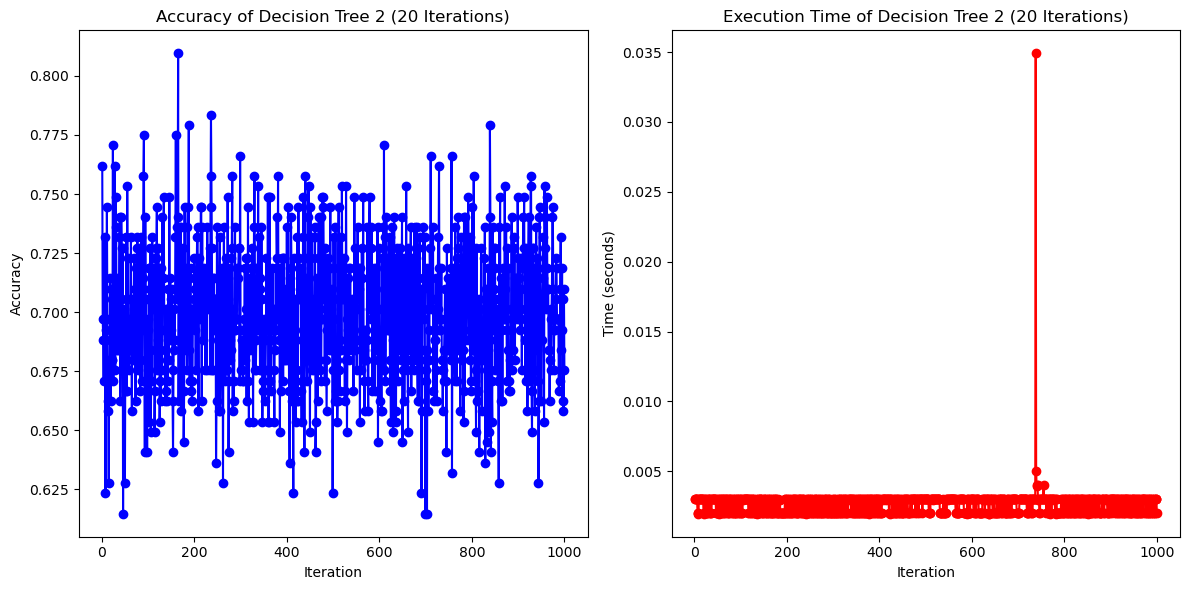

In [75]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Decision Tree 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Decision Tree 2 (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [76]:
# Saving results in respective dictionaries
algorithm_name = "Decision Tree (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Decision Tree (Scaled) is 0.6990692640692642
execution time of  Decision Tree (Scaled) is 0.0026161718368530274
Accuracy std of Decision Tree (Scaled) is 0.028823424658367056


In [77]:
# Logistic Regression Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# آموزش StandardScaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)

# Measuring execution time
    start_time = time.time()

# Building the Logistic Regression model
    model = LogisticRegression(max_iter=200, random_state=i)
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

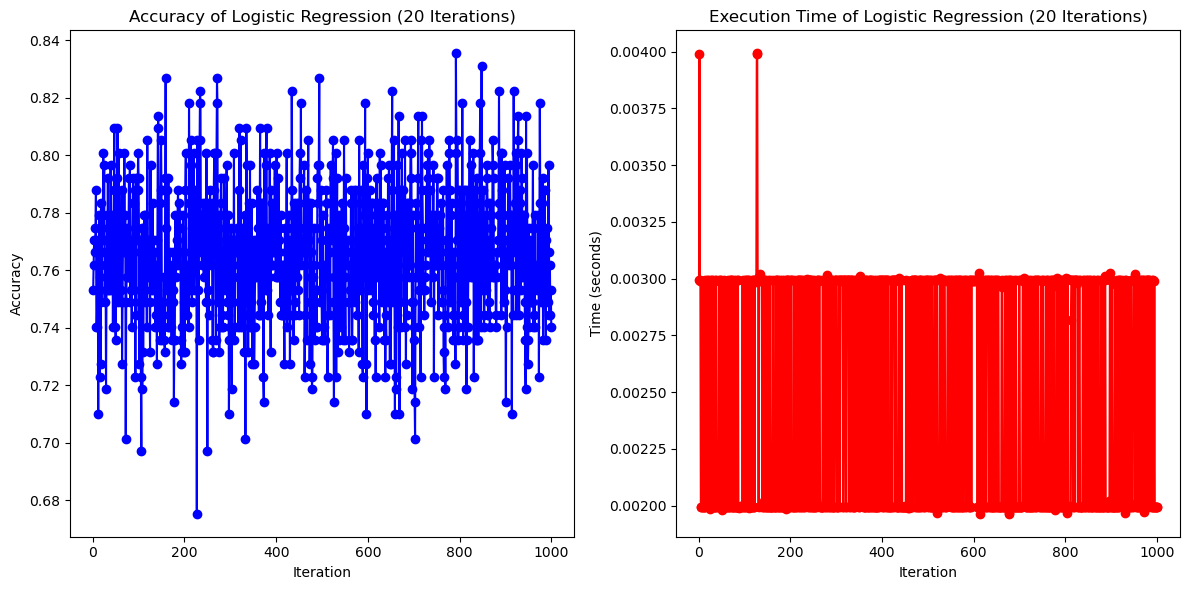

In [78]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Logistic Regression (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [79]:
# Saving results in respective dictionaries
algorithm_name = "Logistic Regression (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  Logistic Regression (Scaled) is 0.7655454545454545
execution time of  Logistic Regression (Scaled) is 0.0024323360919952393
Accuracy std of Logistic Regression (Scaled) is 0.023270449521987743


In [80]:
# Support Vector Machine with Radial Basis Function Kernel Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building SVM model
    model = SVC(kernel='rbf', random_state=i)
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

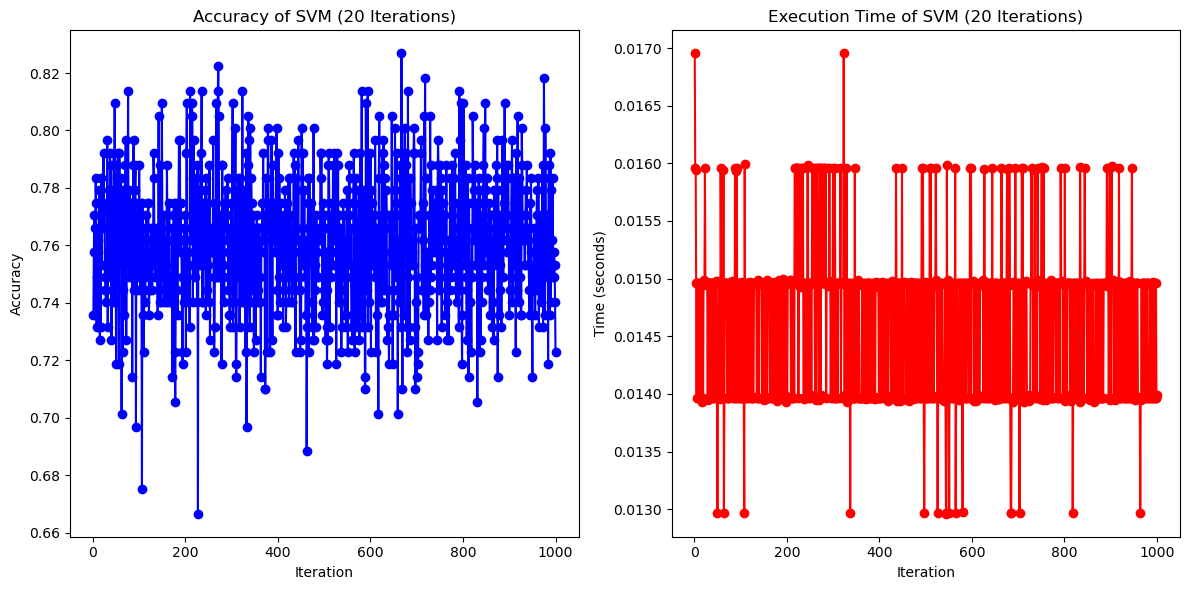

In [81]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of SVM (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [82]:
# Saving results in respective dictionaries
algorithm_name = "SVM (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  SVM (Scaled) is 0.7606753246753246
execution time of  SVM (Scaled) is 0.014590996265411377
Accuracy std of SVM (Scaled) is 0.02271524893239025


In [83]:
# KNN Model
model = KNeighborsClassifier()

# Setting parameters for search (for n_neighbors from 1 to 20)
param_grid = {'n_neighbors': list(range(1, 21))}

scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# GridSearchCV to find the best number of neighbors
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_std, y_train)

# Best parameter and best accuracy
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"Best Accuracy: {best_accuracy}")

Best n_neighbors: 11
Best Accuracy: 0.7615610938040844


In [84]:
# K Neighbors Classifier Implementation
accuracies = []
times = []
all_random_states = []
n_neighbors = best_n_neighbors
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building KNN model
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

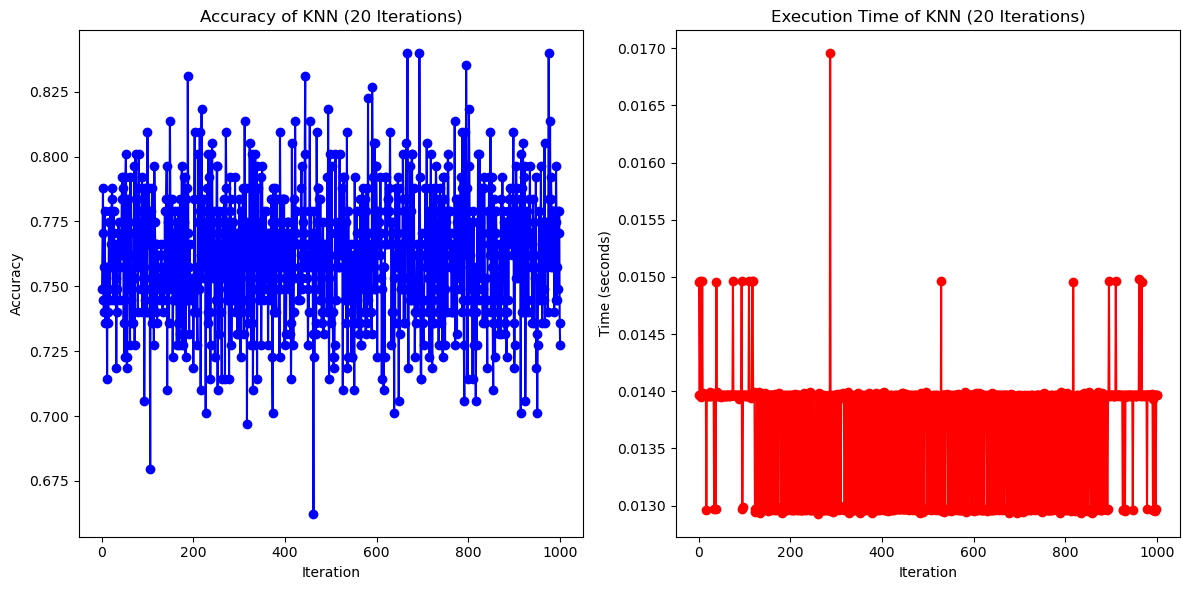

In [85]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of KNN (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [86]:
# Saving results in respective dictionaries
algorithm_name = "KNN (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('accuracy of ', algorithm_name, 'is', mean_accuracy)
print('execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

accuracy of  KNN (Scaled) is 0.7612857142857142
execution time of  KNN (Scaled) is 0.013571627616882324
Accuracy std of KNN (Scaled) is 0.024198534403891907


max_iter = 3000 was enough for other two datasets. but in this case it is not enough and it takes to much time
so I'll leave it with 500 ib this case

In [87]:
# Multi-Layer Perceptron Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# Standard Scaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building MLP model
    model = MLPClassifier(random_state=i, max_iter=500, solver='adam', hidden_layer_sizes=(100,))
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time    
    times.append(time.time() - start_time)

# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

C:\Users\amirm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\amirm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\amirm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\amirm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\amirm\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

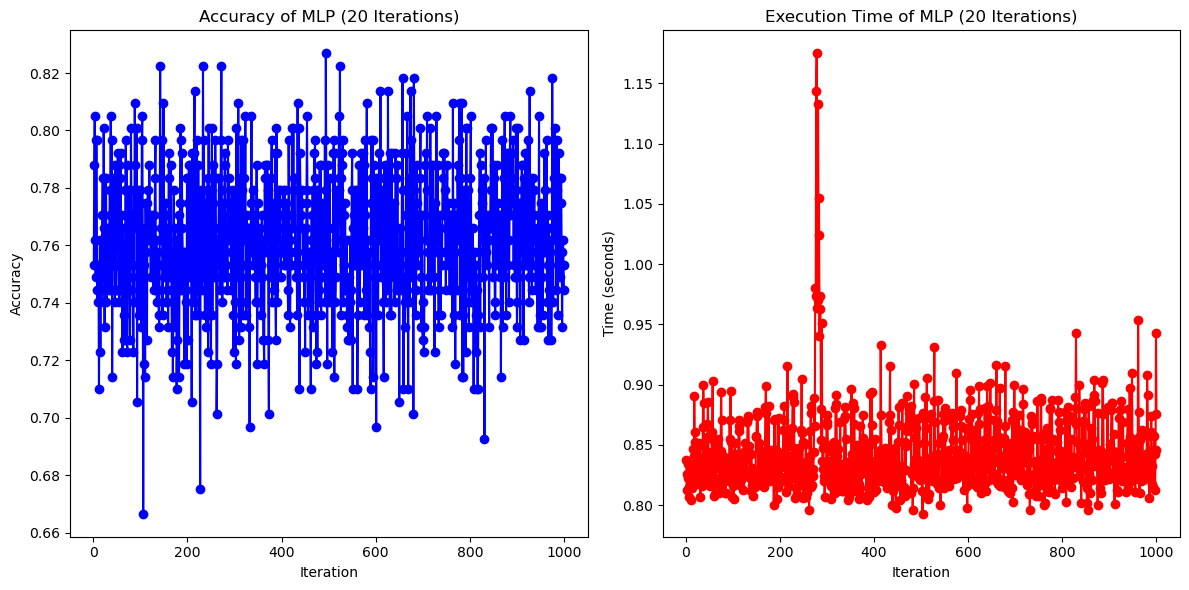

In [88]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of MLP (20 Iterations)')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [89]:
# Saving results in respective dictionaries
algorithm_name = "MLP (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results in respective dictionaries
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  MLP (Scaled) is 0.7619264069264069
Execution time of  MLP (Scaled) is 0.8424893269538879
Accuracy std of MLP (Scaled) is 0.023519275741465444


In [90]:
# Gaussian Naive Bayes Implementation
accuracies = []
times = []
all_random_states = []
for i in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

# آموزش StandardScaler
    scaler_std = StandardScaler()
    X_train_std = scaler_std.fit_transform(X_train)
    X_test_std = scaler_std.transform(X_test)
    
# Measuring execution time
    start_time = time.time()

# Building Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train_std, y_train)

# Making predictions
    y_pred = model.predict(X_test_std)

# Measuring execution time    
    times.append(time.time() - start_time)
    
# Calculating accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
# Recording results for analysis    
    accuracies.append(accuracy)

# Reccording all random states
    all_random_states.append(i)

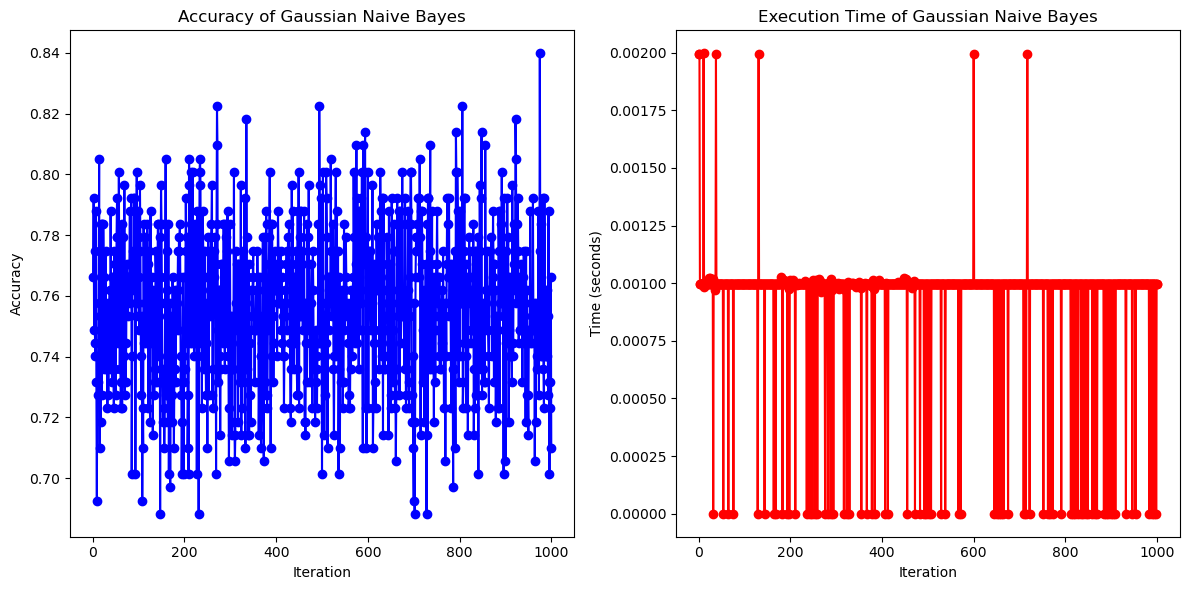

In [91]:
# Creating visualizations
plt.figure(figsize=(12, 6))

# Accuracy performance plot
plt.subplot(1, 2, 1)
plt.plot(range(1, iterations + 1), accuracies, marker='o', color='b')
plt.title('Accuracy of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Execution time plot
plt.subplot(1, 2, 2)
plt.plot(range(1, iterations + 1), times, marker='o', color='r')
plt.title('Execution Time of Gaussian Naive Bayes')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

In [92]:
# Saving results in respective dictionaries
algorithm_name = "Gaussian Naive Bayes (Scaled)"

# Calculating the mean of results
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_time = np.mean(times)

# Best random state
best_random_state = all_random_states[np.argmax(accuracies)]

# Saving results
accuracy_dict[algorithm_name] = mean_accuracy
accuracy_std_dict[algorithm_name] = std_accuracy
time_dict[algorithm_name] = mean_time
best_random_states[algorithm_name] = best_random_state

# Output the mean values
print('Accuracy of ', algorithm_name, 'is', mean_accuracy)
print('Execution time of ', algorithm_name, 'is', mean_time)
print('Accuracy std of', algorithm_name, 'is', std_accuracy)

Accuracy of  Gaussian Naive Bayes (Scaled) is 0.7554285714285714
Execution time of  Gaussian Naive Bayes (Scaled) is 0.0009255774021148681
Accuracy std of Gaussian Naive Bayes (Scaled) is 0.02521695519996749


In [93]:
colors=['darkblue', 'darkviolet', 'darkslategray', 'darkred', 'steelblue',
        'darkgreen', 'darkcyan', 'black', 'darkorange', 'saddlebrown', 'deeppink']

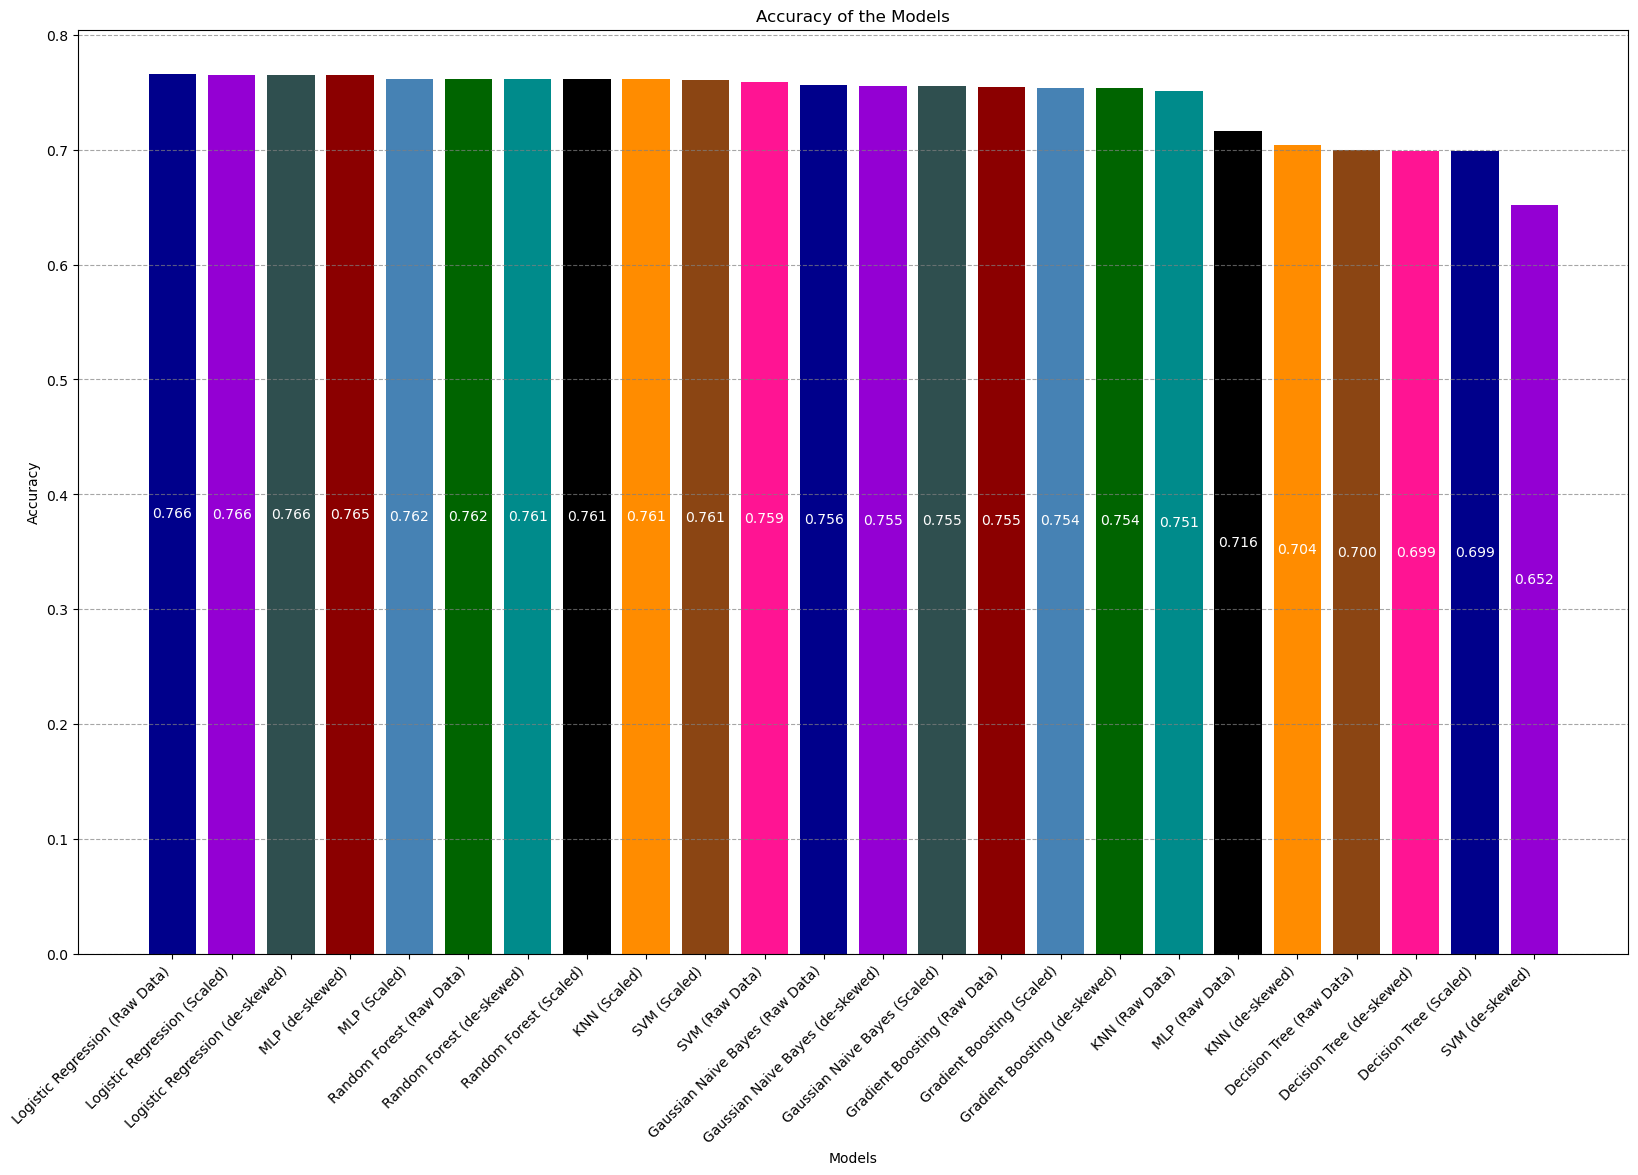

In [94]:
sorted_accuracy_dict = dict(sorted(accuracy_dict.items(), key=lambda item: item[1], reverse=True))
labels = sorted_accuracy_dict.keys()
values = sorted_accuracy_dict.values()

# Creating visualizations
plt.figure(figsize=(20, 12))
bars = plt.bar(labels, values, color=colors, width=0.8) 
plt.xticks(rotation=45, ha='right')
plt.title('Accuracy of the Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')

for bar in bars:
    bar_height = bar.get_height()
    # Placing the value inside each bar with 3 decimal places
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height / 2,  
            f"{bar_height:.3f}", ha='center', va='center', fontsize=10, color='white')

plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)

plt.show()

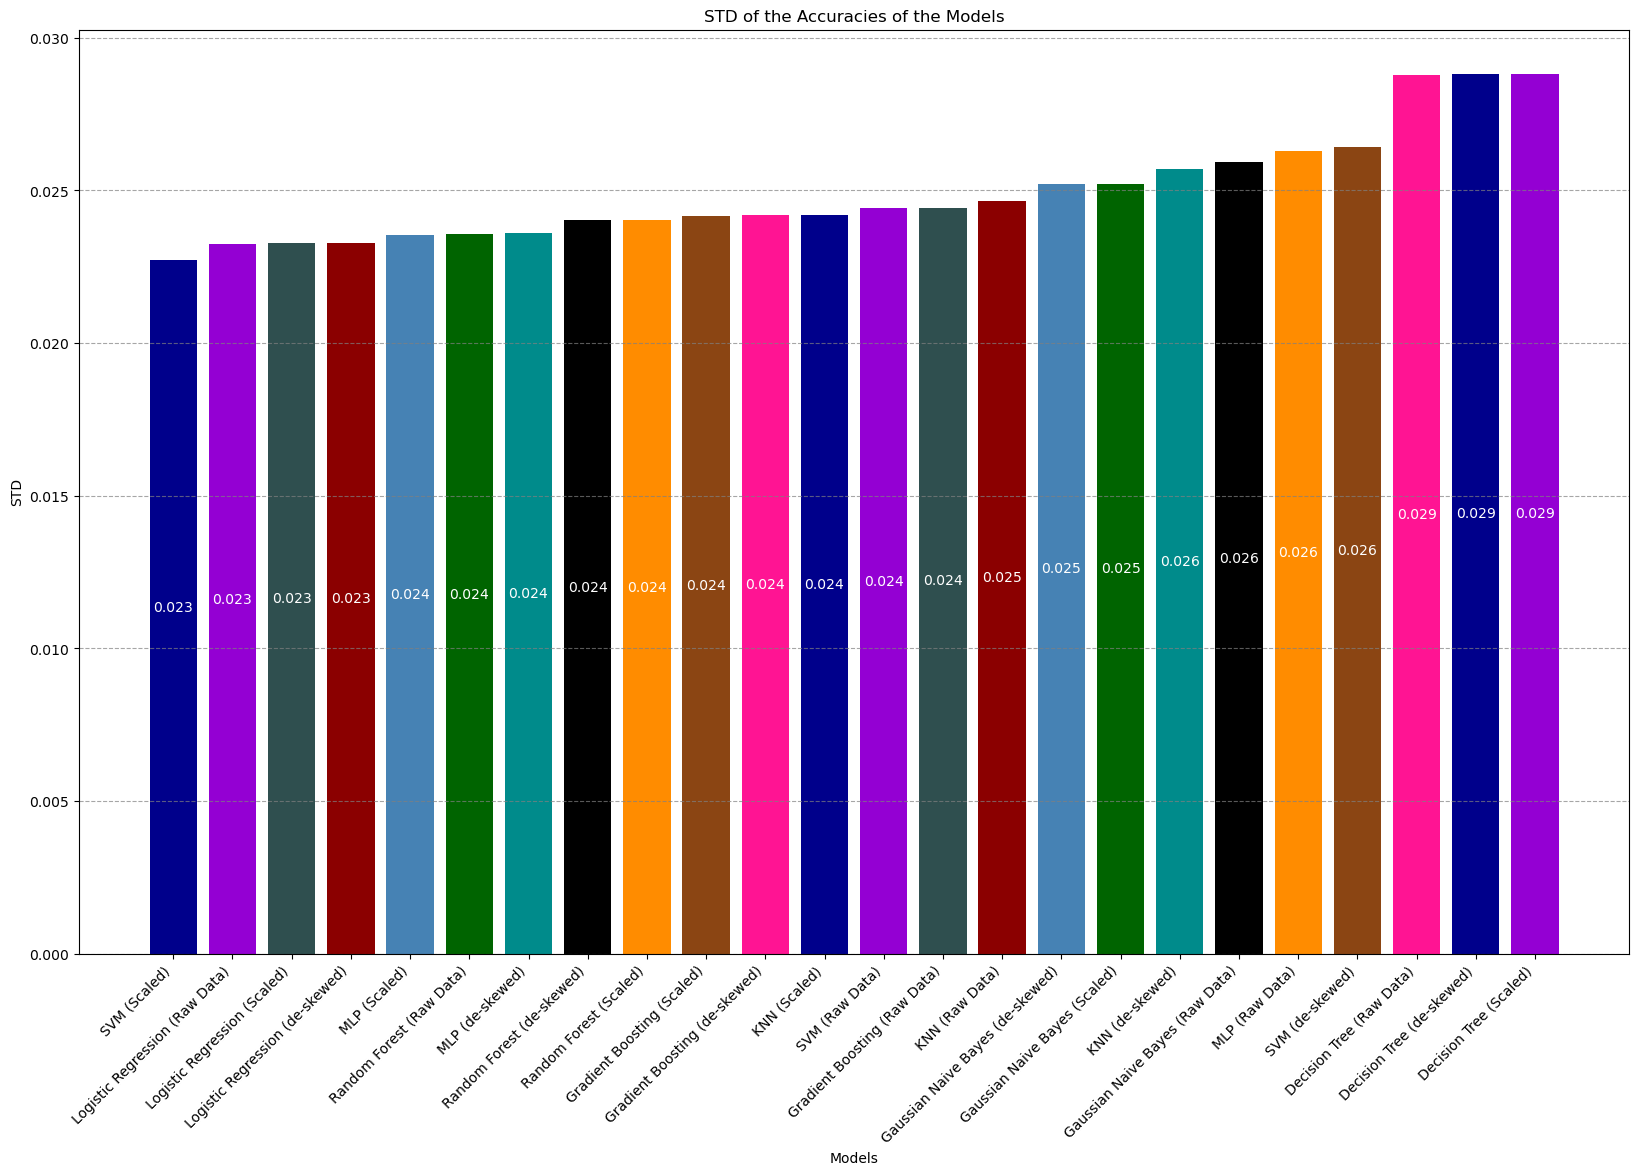

In [95]:
sorted_std_dict = dict(sorted(accuracy_std_dict.items(), key=lambda item: item[1]))
labels = sorted_std_dict.keys()
values = sorted_std_dict.values()

# Creating visualizations
plt.figure(figsize=(20, 12))
plt.bar(labels, values, color=colors, width=0.8) 
plt.xticks(rotation=45, ha='right')
plt.title('STD of the Accuracies of the Models')
plt.xlabel('Models')
plt.ylabel('STD')

bars = plt.bar(labels, values, color=colors, width=0.6) 

for bar in bars:
    bar_height = bar.get_height()
    # Placing the value inside each bar with 3 decimal places
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height / 2,  
            f"{bar_height:.3f}", ha='center', va='center', fontsize=10, color='white')

plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)

plt.show()

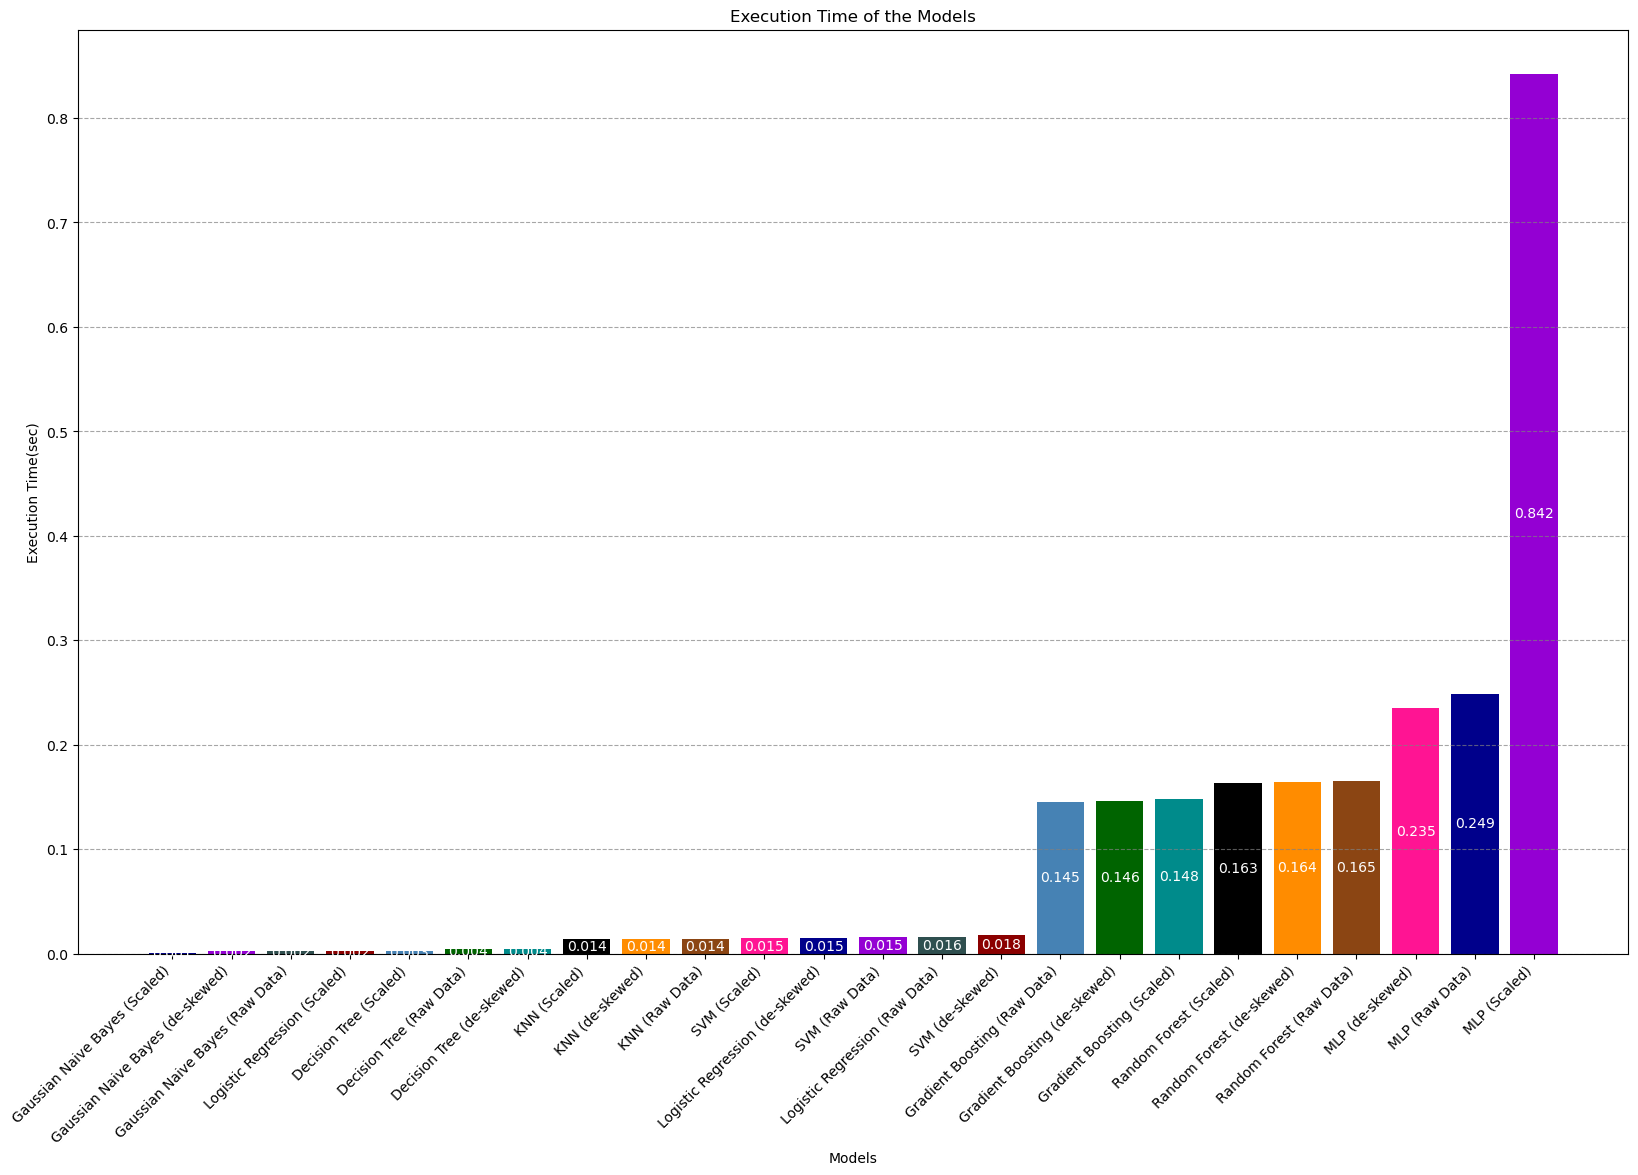

In [96]:
sorted_time_dict = dict(sorted(time_dict.items(), key=lambda item: item[1]))
labels = sorted_time_dict.keys()
values = sorted_time_dict.values()

# Creating visualizations
plt.figure(figsize=(20, 12))
plt.bar(labels, values, color=colors, width=0.8) 
plt.xticks(rotation=45, ha='right')
plt.title('Execution Time of the Models')
plt.xlabel('Models')
plt.ylabel('Execution Time(sec)')

bars = plt.bar(labels, values, color=colors, width=0.6) 

for bar in bars:
    bar_height = bar.get_height()
    # Placing the value inside each bar with 3 decimal places
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height / 2,  
            f"{bar_height:.3f}", ha='center', va='center', fontsize=10, color='white')

plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)

plt.show()

In [97]:
final_scores = {}
for key in accuracy_dict.keys():
    final_score = (((accuracy_dict[key] * 2) / accuracy_std_dict[key]) / 1000)
    final_scores[key] = final_score

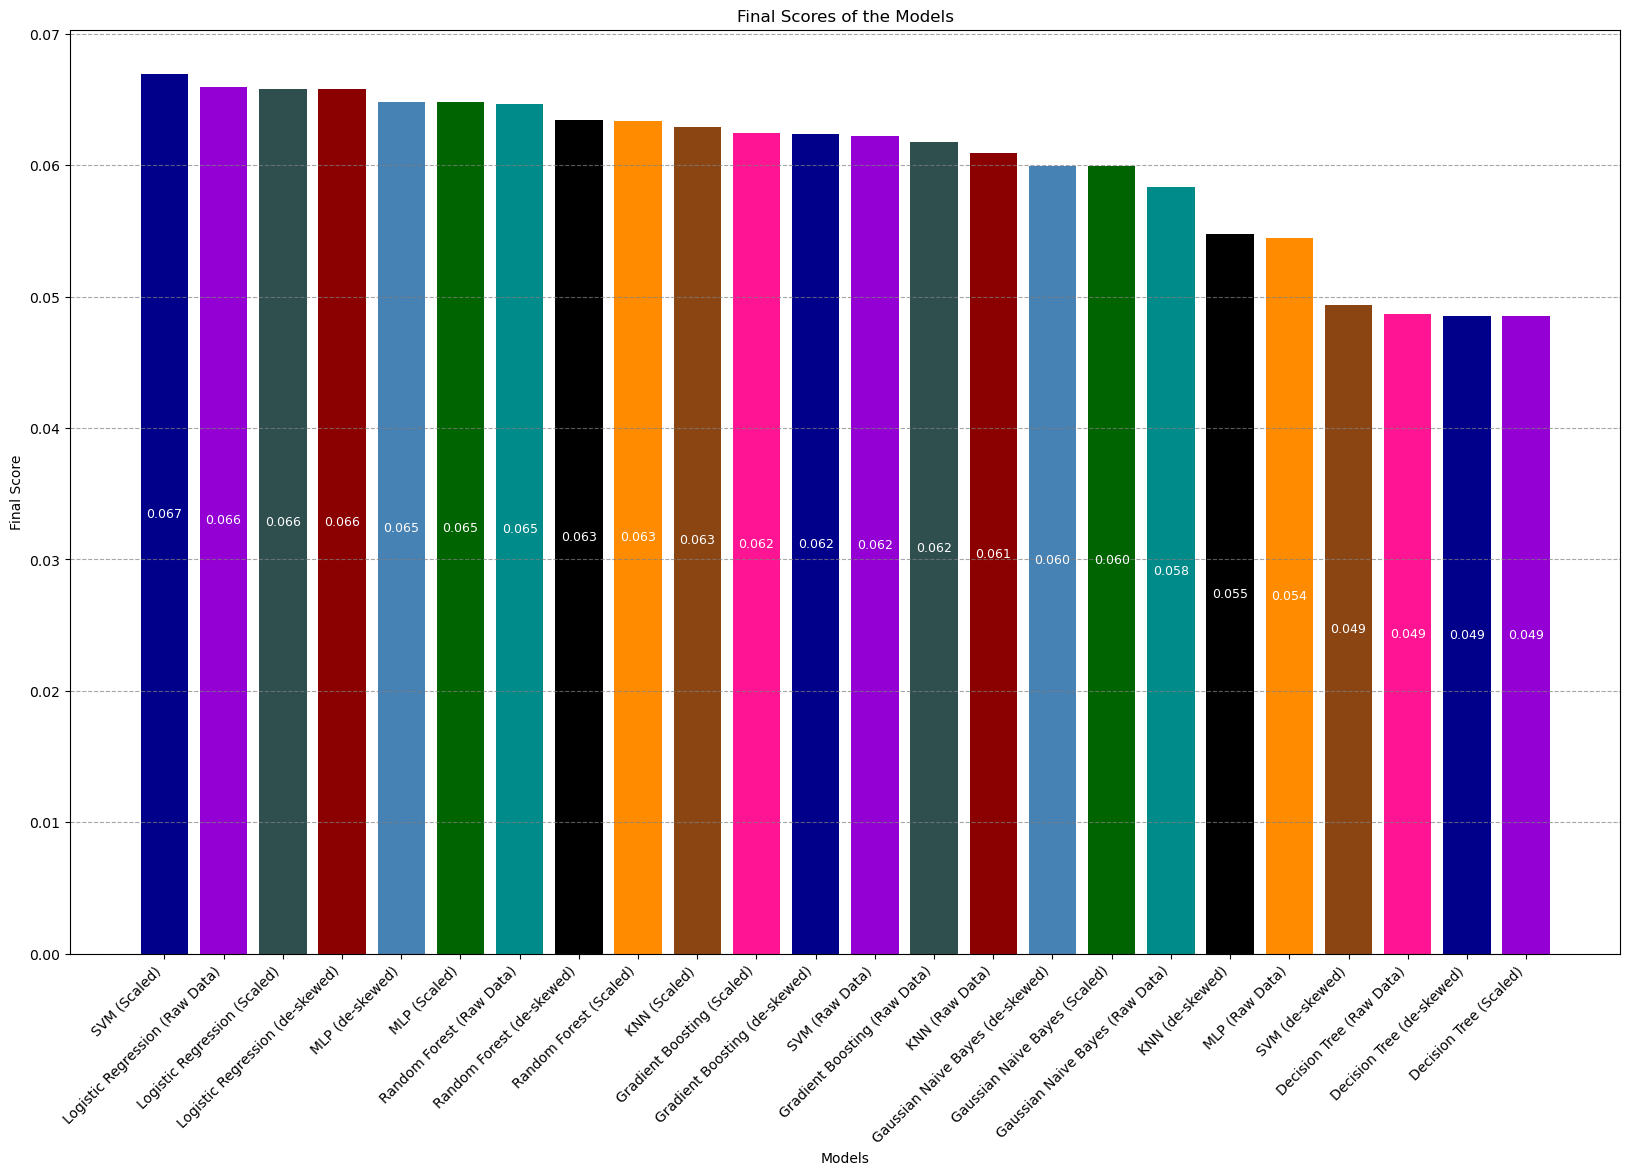

In [98]:
sorted_final_scores = dict(sorted(final_scores.items(), key=lambda item: item[1], reverse=True))
labels = sorted_final_scores.keys()
values = sorted_final_scores.values()

# Creating visualizations
plt.figure(figsize=(20, 12))
bars = plt.bar(labels, values, color=colors, width=0.8) 
plt.xticks(rotation=45, ha='right')
plt.title('Final Scores of the Models')
plt.xlabel('Models')
plt.ylabel('Final Score')

for bar in bars:
    bar_height = bar.get_height()
    # Placing the value inside each bar with 3 decimal places
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height / 2,  
            f"{bar_height:.3f}", ha='center', va='center', fontsize=9, color='white')

plt.grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)

plt.show()

In [99]:
print(best_random_states)

{'Random Forest (Raw Data)': 849, 'Gradient Boosting (Raw Data)': 849, 'Decision Tree (Raw Data)': 406, 'Logistic Regression (Raw Data)': 142, 'SVM (Raw Data)': 425, 'KNN (Raw Data)': 588, 'MLP (Raw Data)': 698, 'Gaussian Naive Bayes (Raw Data)': 742, 'Random Forest (de-skewed)': 849, 'Gradient Boosting (de-skewed)': 849, 'Decision Tree (de-skewed)': 406, 'Logistic Regression (de-skewed)': 417, 'SVM (de-skewed)': 242, 'KNN (de-skewed)': 603, 'MLP (de-skewed)': 585, 'Gaussian Naive Bayes (de-skewed)': 849, 'Random Forest (Scaled)': 849, 'Gradient Boosting (Scaled)': 265, 'Decision Tree (Scaled)': 406, 'Logistic Regression (Scaled)': 417, 'SVM (Scaled)': 645, 'KNN (Scaled)': 645, 'MLP (Scaled)': 742, 'Gaussian Naive Bayes (Scaled)': 849}
